# 5. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

## 5-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

---

[2019 2nd ML month with KaKR
캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview)

### 목차
1. 데이터 살펴보기
2. 간단한 전처리
3. 모델링

---

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
# 필요한 라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd # Analysis 
import numpy as np  # Analysis 

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt  # Visulization
import seaborn as sns  # Visulization

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV


from scipy.stats import norm  # Analysis 
from sklearn.preprocessing import StandardScaler  # Analysis
from scipy import stats  # Analysis 
import gc

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
>1. ID : 집을 구분하는 번호
>2. date : 집을 구매한 날짜
>3. price : 타겟 변수인 집의 가격
>4. bedrooms : 침실의 수
>5. bathrooms : 침실당 화장실 개수
>6. sqft_living : 주거 공간의 평방 피트
>7. sqft_lot : 부지의 평방 피트
>8. floors : 집의 층수
>9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
>10. view : 집이 얼마나 좋아 보이는지의 정도
>11. condition : 집의 전반적인 상태
>12. grade : King County grading 시스템 기준으로 매긴 집의 등급
>13. sqft_above : 지하실을 제외한 평방 피트
>14. sqft_basement : 지하실의 평방 피트
>15. yr_built : 집을 지은 년도
>16. yr_renovated : 집을 재건축한 년도
>17. zipcode : 우편번호
>18. lat : 위도
>19. long : 경도
>20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
>21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [43]:
# csv 파일 경로
data_dir = 'kaggle_kakr_housing'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')  # 테스트, 즉 submission 시 사용할 데이터 경로

In [44]:
# csv 파일 불러오기
train_original = pd.read_csv(train_data_path)

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [45]:
# 전체 데이터 자료형 보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

- 독립변수
  - 연속형 변수 : ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
  - 비연속형 변수 : ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
- 목적변수(target)
  - ['price']

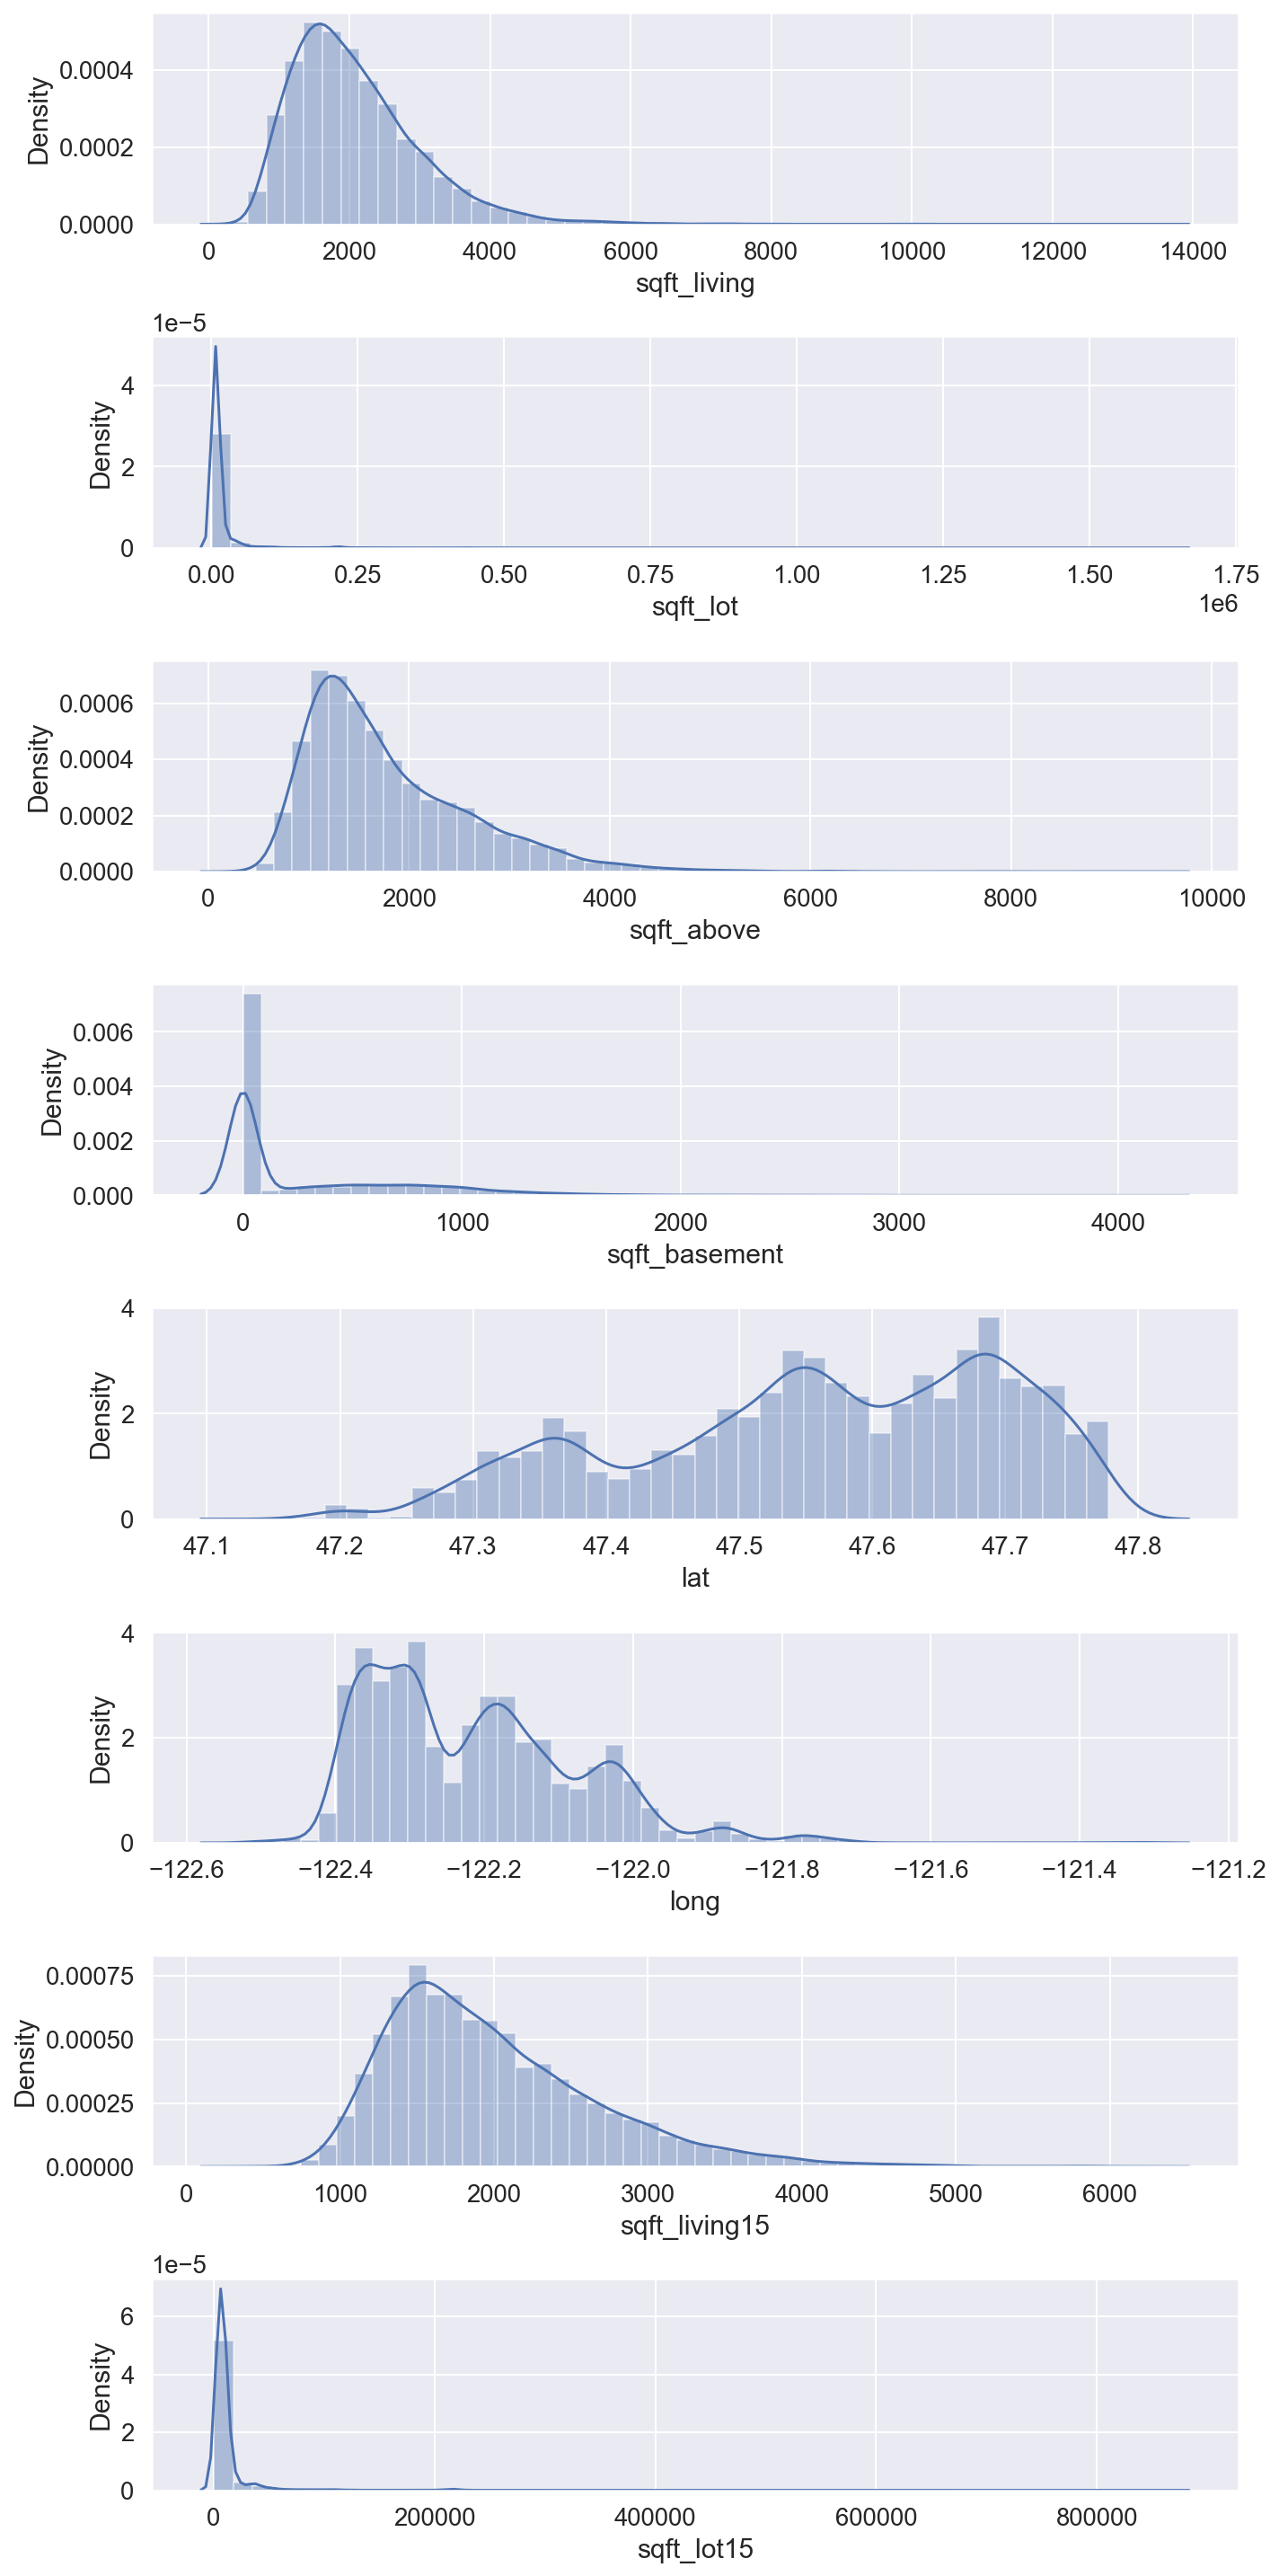

In [46]:
# 연속형 변수의 분포
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
plt.figure(figsize=(10,20))
count = 1
for col in continuous:
    plt.subplot(len(continuous), 1, count)
    # plt.title(col)
    sns.distplot(train[col])
    count += 1
plt.tight_layout()

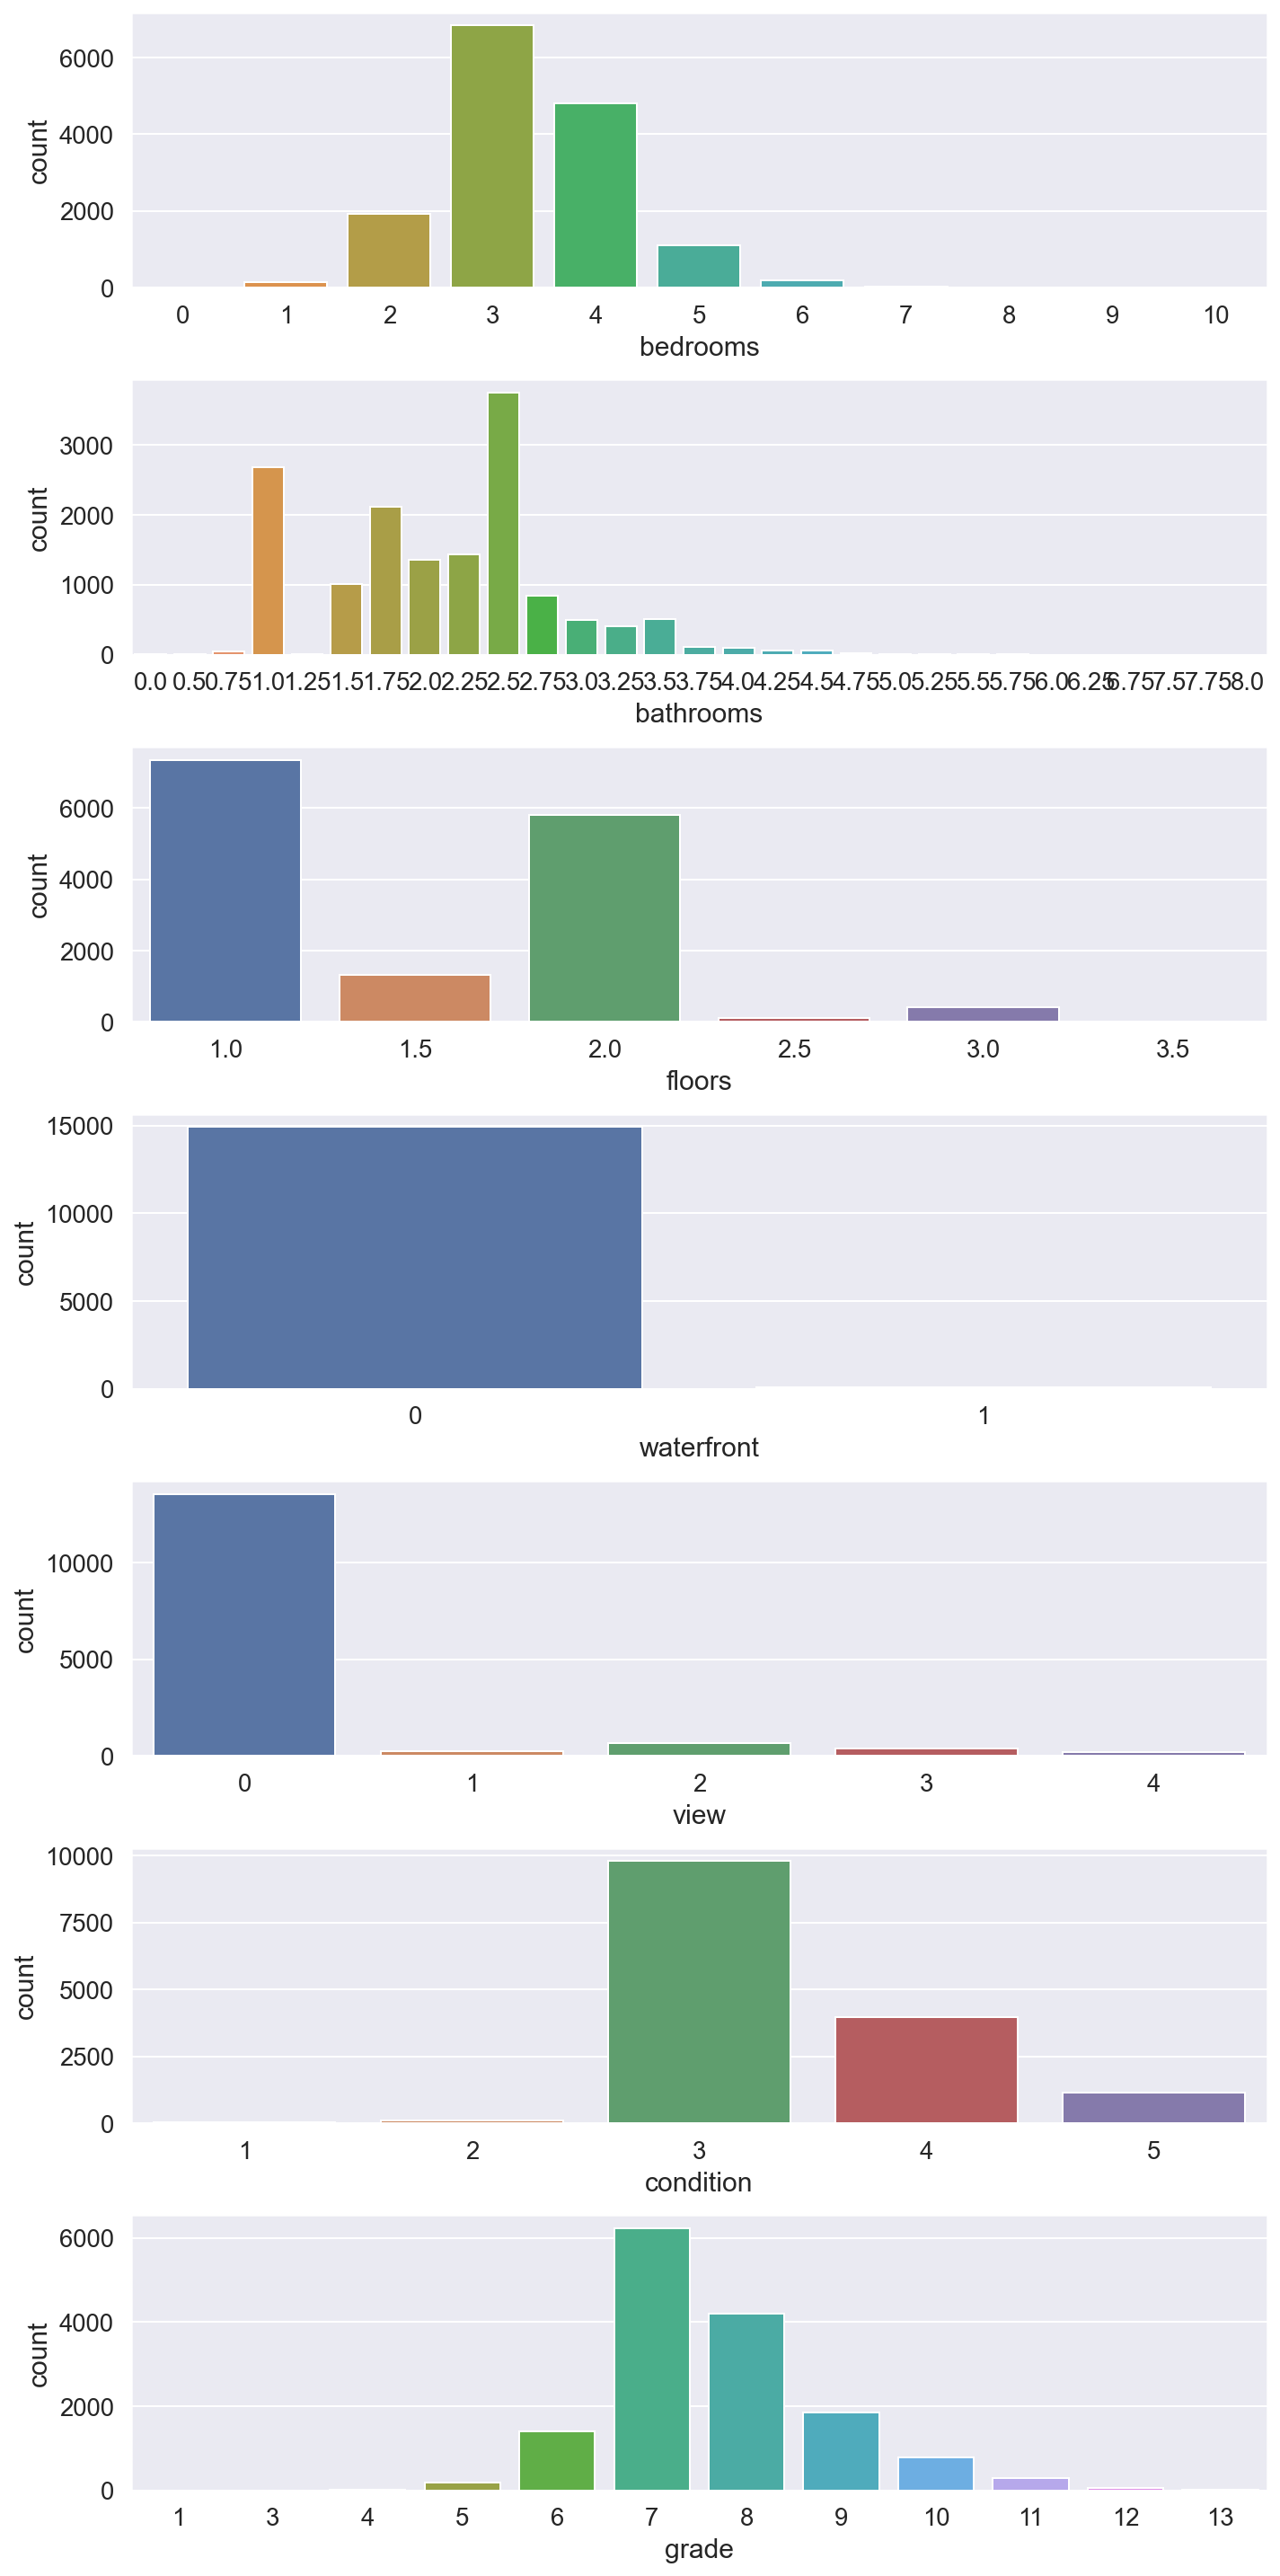

In [47]:
# 비연속형 변수의 빈도분포
# yr_built, yr_renovated, zipcode는 제외
non_continuous = ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade']
plt.figure(figsize=(10,20))
count = 1
for col in non_continuous:
    plt.subplot(len(non_continuous), 1, count)
    # plt.title(col)
    sns.countplot(x=col,data=train)
    count += 1
plt.tight_layout()

In [48]:
train.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  15035.000000  1.503500e+04  15035.000000  15035.000000  15035.000000   
mean    7517.000000  5.406827e+05      3.369139      2.115065   2083.790223   
std     4340.374984  3.715247e+05      0.902721      0.767519    922.134087   
min        0.000000  7.800000e+04      0.000000      0.000000    290.000000   
25%     3758.500000  3.220000e+05      3.000000      1.750000   1430.000000   
50%     7517.000000  4.500000e+05      3.000000      2.250000   1910.000000   
75%    11275.500000  6.450000e+05      4.000000      2.500000   2560.000000   
max    15034.000000  7.700000e+06     10.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.503500e+04  15035.000000  15035.000000  15035.000000  15035.000000   
mean   1.529697e+04      1.498071      0.007117      0.234253      3.406651   
std    4.261282e+04      0.538522      0.084063      0.763376      0.646505   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.027500e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.620000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.069550e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  15035.000000  15035.000000   15035.000000  15035.000000  15035.000000   
mean       7.660725   1794.158164     289.632059   1971.100432     83.798936   
std        1.179803    831.738609     440.663284     29.407612    400.398498   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1570.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2230.000000     550.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4130.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  15035.000000  15035.000000  15035.000000   15035.000000   15035.000000  
mean   98078.031726     47.560721   -122.213677    1992.754772   12823.884935  
std       53.297815      0.138164      0.141294     691.456442   27736.259787  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.472700   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571900   -122.231000    1850.000000    7610.000000  
75%    98117.000000     47.678300   -122.126000    2360.000000   10076.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

## 2. 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

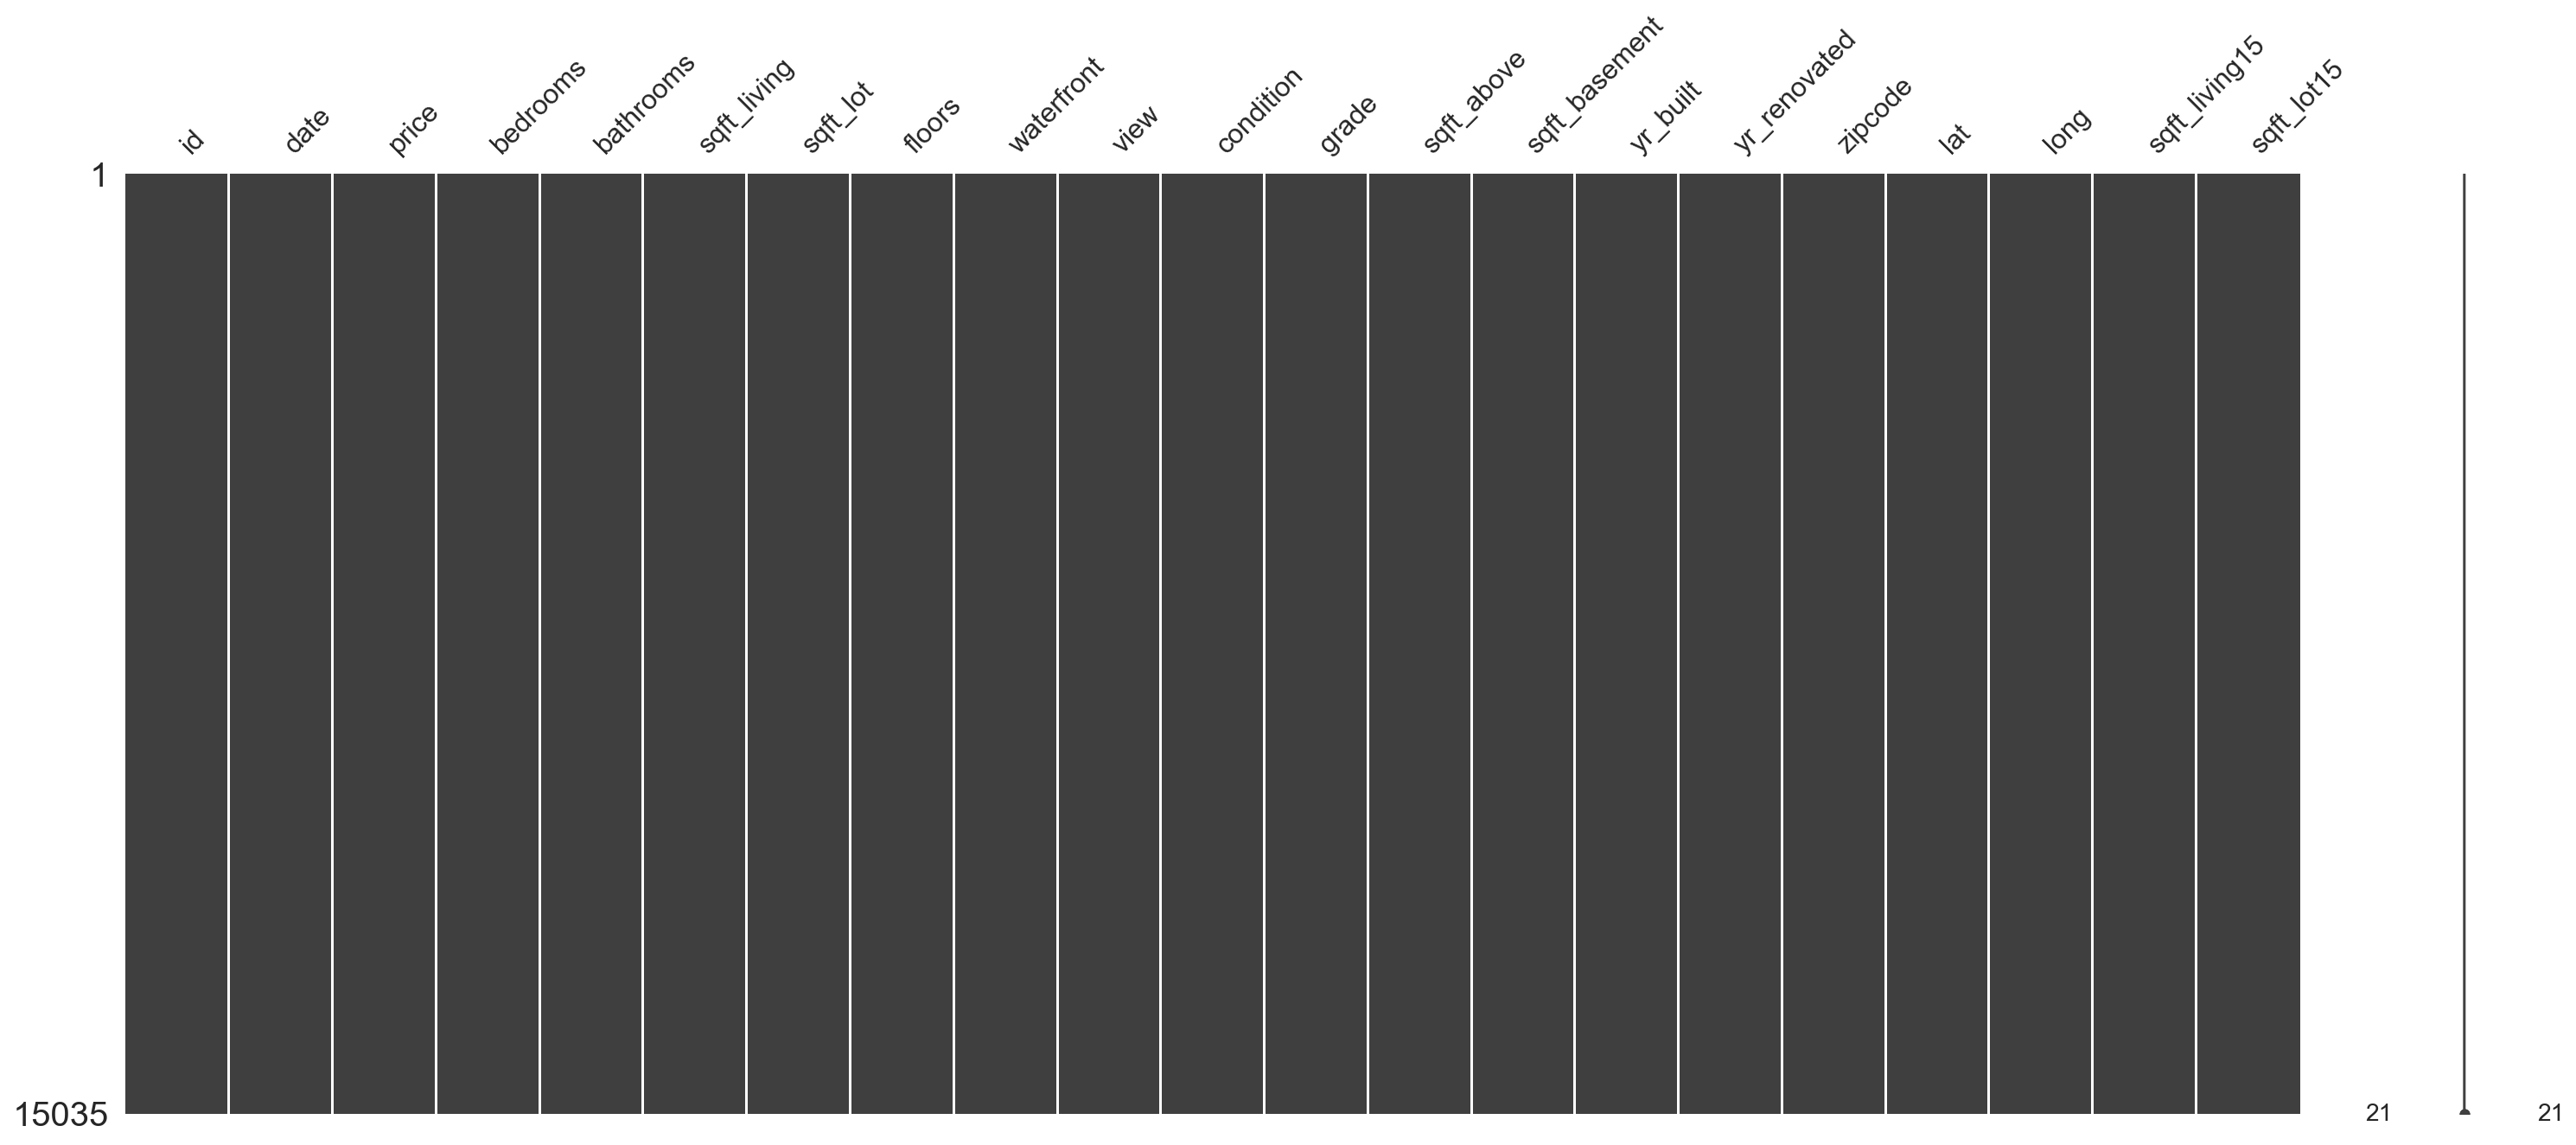

In [49]:
msno.matrix(train)

In [50]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


- 결측치가 없음을 확인할 수 있다.

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [51]:
# TypeError 때문에 date 컬럼 데이터를 년월일까지 잘라내서 int로 변경(수치화)
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)

# train_data 에서 date 컬럼 타입을 int 로 변경한 것처럼 test_data 에서도 똑같이 적용해야 함
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미친다.

=> 다듬어줄 필요가 있다.

=> log-scaling 적용

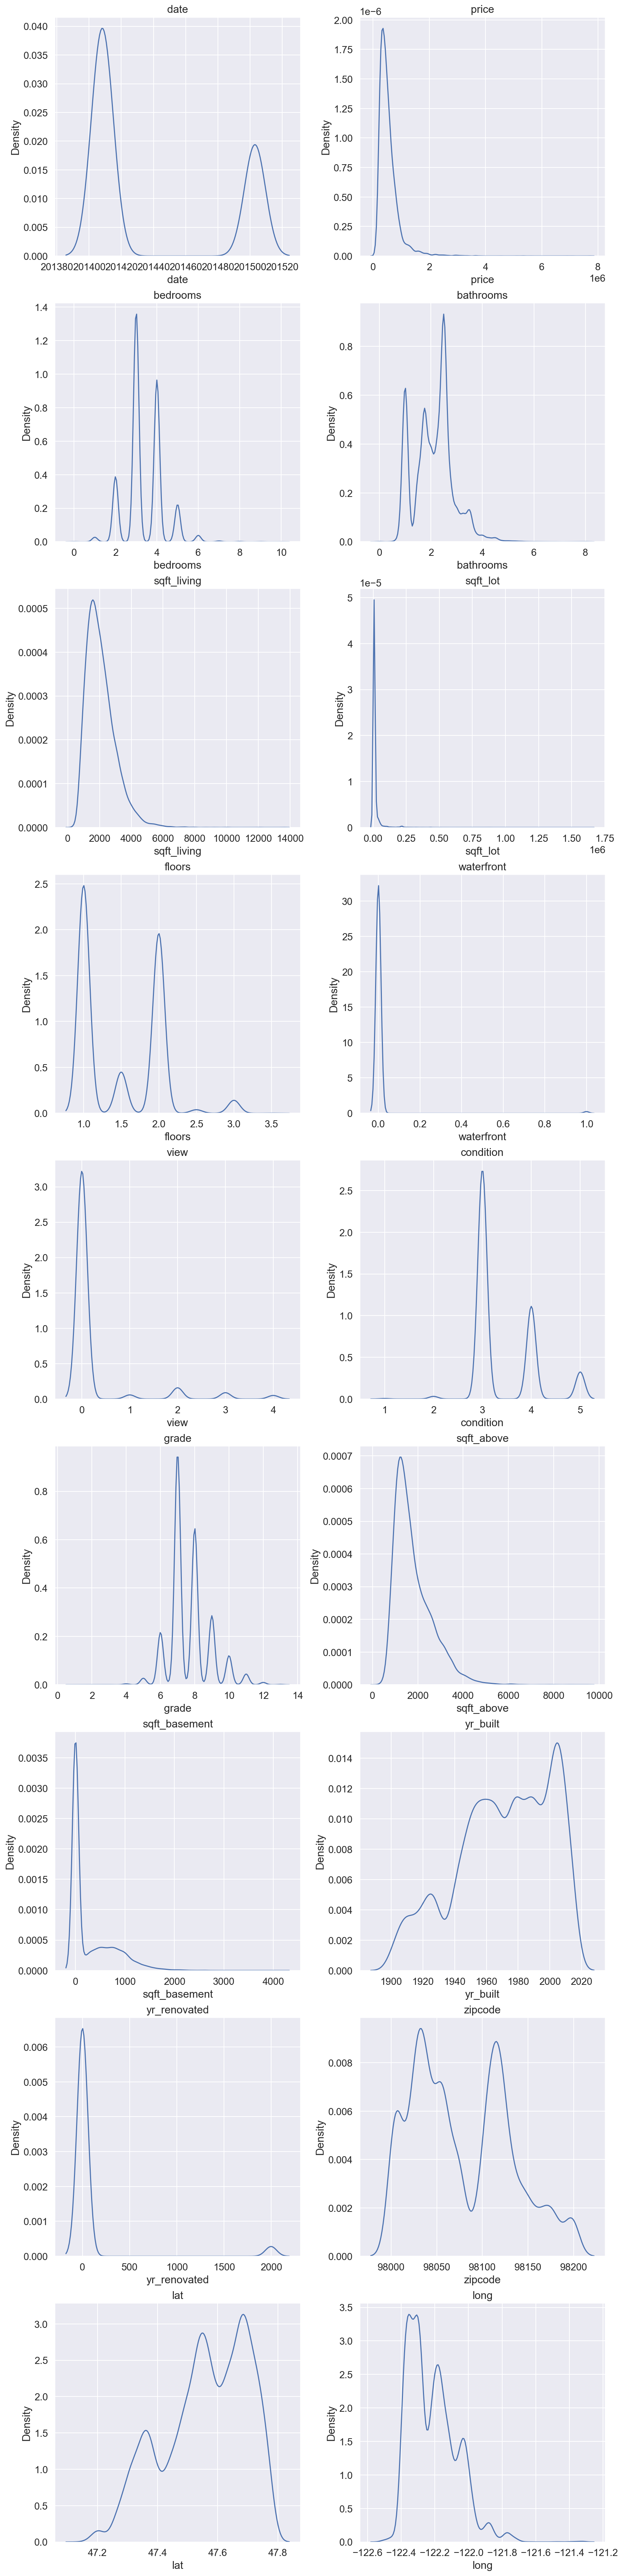

In [52]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50), constrained_layout=True)

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

- 한쪽으로 치우친 변수들: price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement

=> log-scaling 을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다.

In [53]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

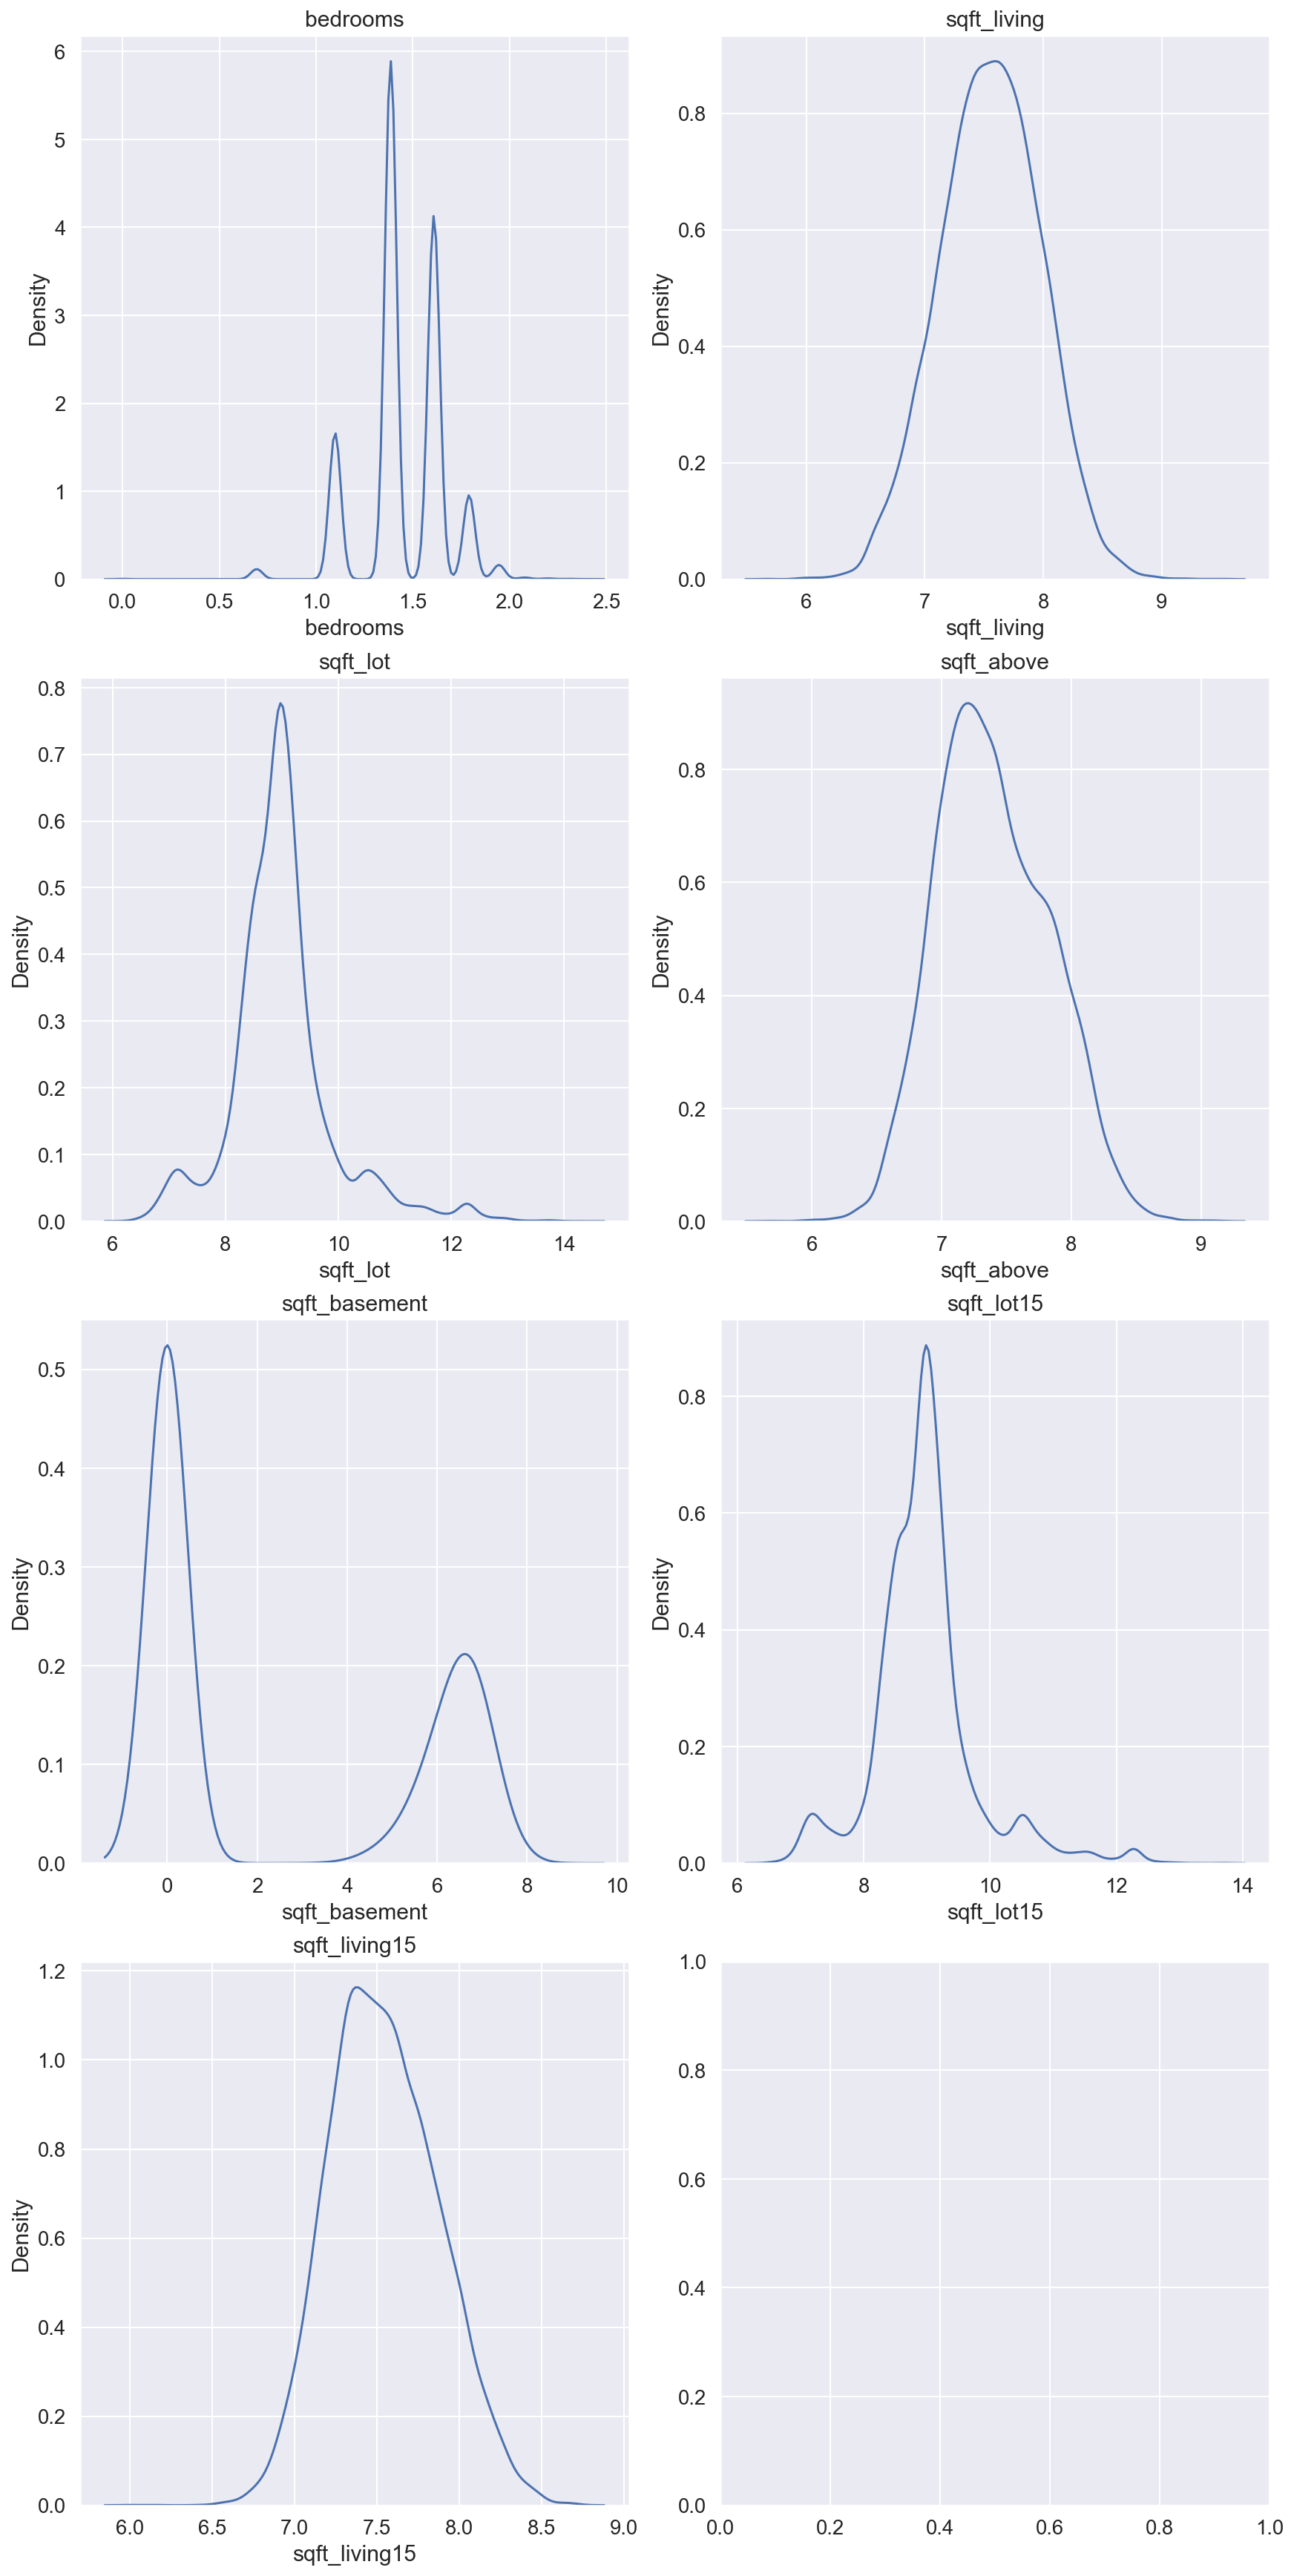

In [54]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24), constrained_layout=True)

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있다.

### 목적변수(price)

- 목적변수(price) 데이터 통계 요약

In [55]:
# descriptive statistics summary
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

- 목적변수(price) 분포 확인
  - minx과 max의 차이가 큼 => std가 큼
  - 왼쪽으로 치우쳐진 것을 볼 수 있다.

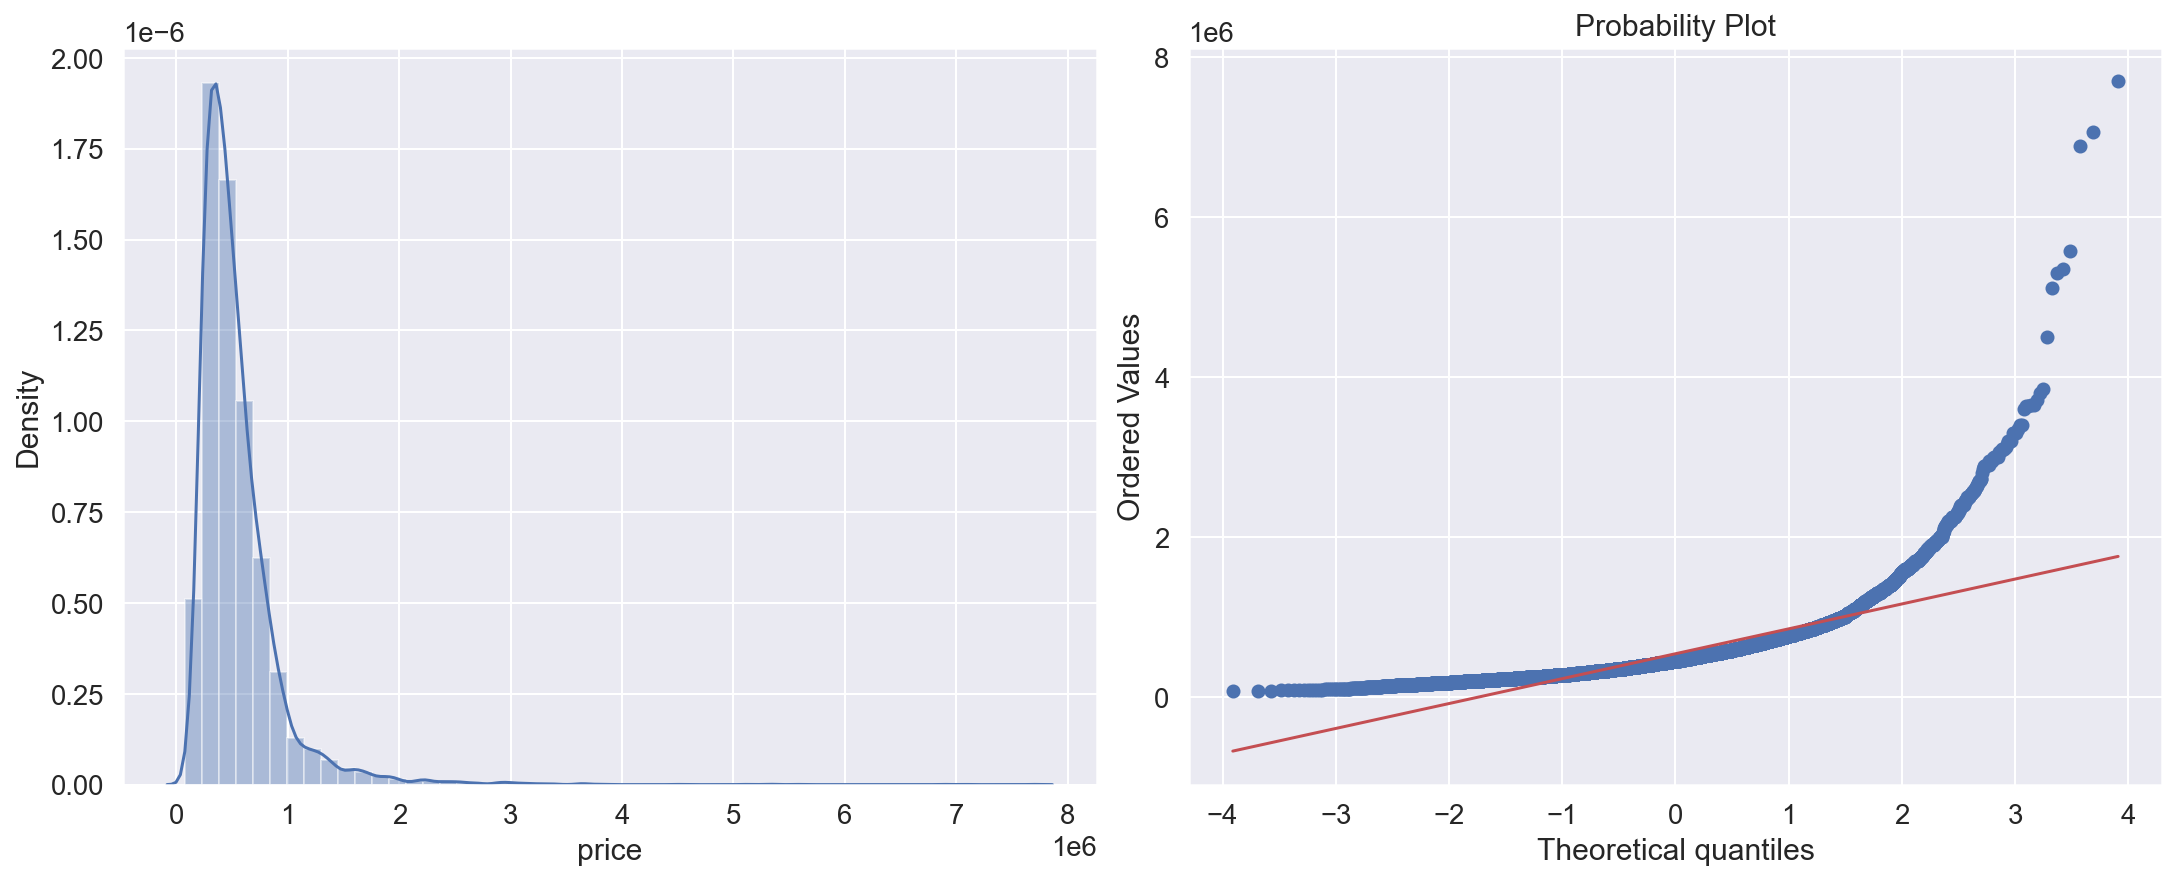

In [56]:
# plt.subplots
f, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
plt.subplot(121)
sns.distplot(train['price'])

plt.subplot(122)
res = stats.probplot(train['price'], plot=plt)

- 목적변수(price) 로그화 후 분포 확인
  - numpy.log1p() 함수 사용
  - log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만듦
  - => 치우침이 줄어든 분포를 확인할 수 있다.
  - 모델 예측이 끝나고 numpy.exp1m() 함수로 값을 되돌려야 함

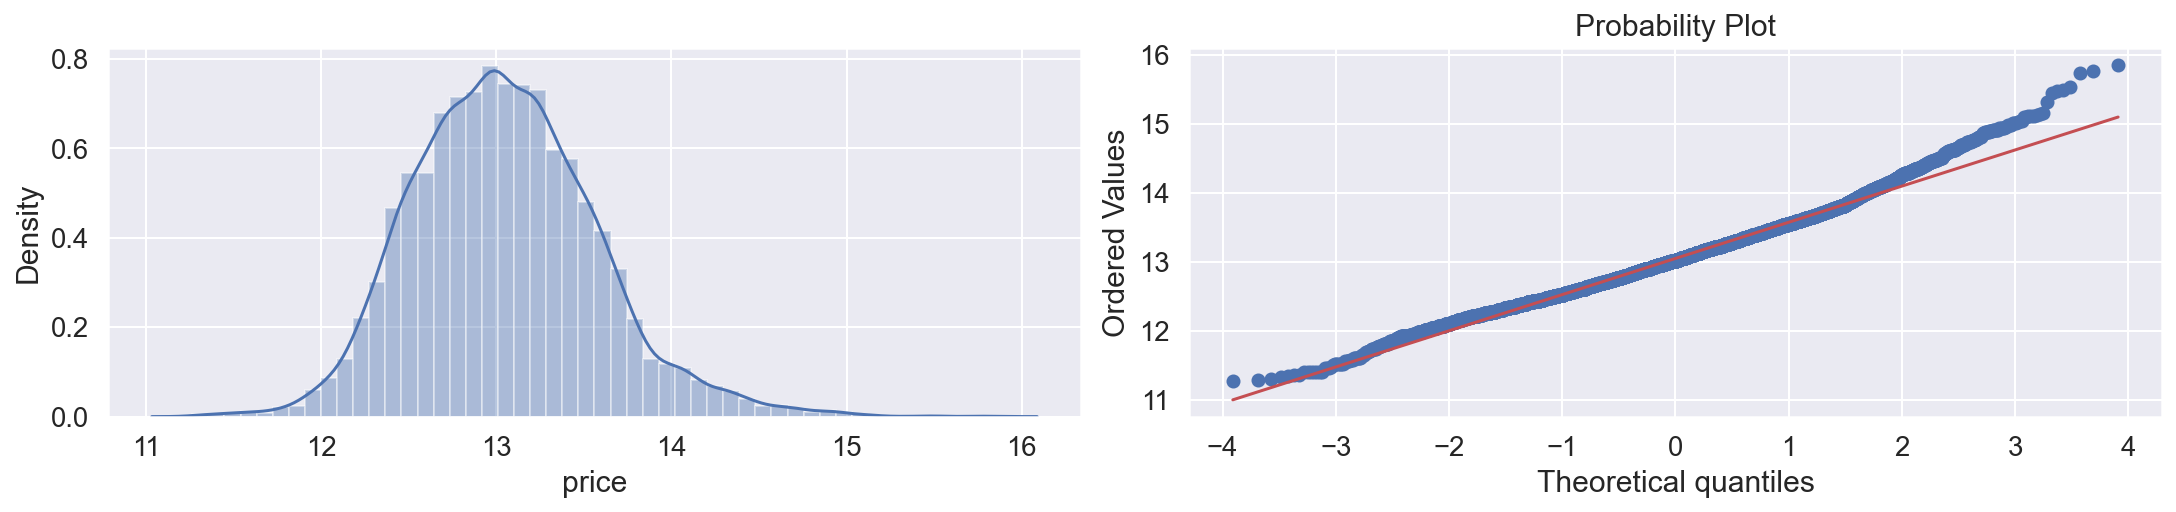

In [57]:
# plt.subplots
f, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
plt.subplot(223)
sns.distplot(np.log1p(train['price']))

plt.subplot(224)
res = stats.probplot(np.log1p(train['price']), plot=plt)

In [58]:
# 목적변수 price 에 log-scaling 적용
train['price'] = np.log1p(train['price'])

### 반응변수 시각화

- 전체 column과 price의 상관관계

In [60]:
# 컬럼 간 상관 계수 계산
train_corr = train.corr(method='spearman')

train_corr

id      date     price  bedrooms  bathrooms  sqft_living  \
id             1.000000 -0.011225  0.036892  0.013834   0.111903     0.043499   
date          -0.011225  1.000000 -0.001679 -0.010816  -0.026912    -0.023377   
price          0.036892 -0.001679  1.000000  0.350185   0.498989     0.646482   
bedrooms       0.013834 -0.010816  0.350185  1.000000   0.523963     0.649001   
bathrooms      0.111903 -0.026912  0.498989  0.523963   1.000000     0.748612   
sqft_living    0.043499 -0.023377  0.646482  0.649001   0.748612     1.000000   
sqft_lot      -0.141132 -0.006984  0.080554  0.217457   0.068576     0.307893   
floors         0.173174 -0.018152  0.328674  0.233211   0.552080     0.408417   
waterfront    -0.011775  0.002684  0.113179 -0.008354   0.058399     0.072606   
view          -0.027046  0.012829  0.291720  0.079330   0.150776     0.227205   
condition     -0.108179 -0.048159  0.021520  0.017853  -0.163990    -0.059271   
grade          0.091820 -0.026455  0.662125  0.386833   0.661112     0.717800   
sqft_above     0.072526 -0.014819  0.547868  0.540893   0.695672     0.846081   
sqft_basement -0.043541 -0.007491  0.245304  0.229599   0.185469     0.322338   
yr_built       0.232404  0.004702  0.097844  0.180364   0.564570     0.352702   
yr_renovated  -0.029928 -0.023582  0.112381  0.020432   0.054849     0.059647   
zipcode       -0.002220 -0.002105 -0.009266 -0.171497  -0.206889    -0.209218   
lat           -0.001464 -0.027470  0.450692 -0.022815   0.000765     0.025544   
long           0.006746  0.001828  0.071757  0.195264   0.267203     0.292975   
sqft_living15  0.019945 -0.017750  0.573777  0.445933   0.575235     0.748214   
sqft_lot15    -0.134385 -0.007397  0.065771  0.201626   0.062854     0.286527   

               sqft_lot    floors  waterfront      view  ...     grade  \
id            -0.141132  0.173174   -0.011775 -0.027046  ...  0.091820   
date          -0.006984 -0.018152    0.002684  0.012829  ... -0.026455   
price          0.080554  0.328674    0.113179  0.291720  ...  0.662125   
bedrooms       0.217457  0.233211   -0.008354  0.079330  ...  0.386833   
bathrooms      0.068576  0.552080    0.058399  0.150776  ...  0.661112   
sqft_living    0.307893  0.408417    0.072606  0.227205  ...  0.717800   
sqft_lot       1.000000 -0.235869    0.088030  0.118640  ...  0.156199   
floors        -0.235869  1.000000    0.030272  0.020704  ...  0.504506   
waterfront     0.088030  0.030272    1.000000  0.275925  ...  0.065167   
view           0.118640  0.020704    0.275925  1.000000  ...  0.211469   
condition      0.118165 -0.285500    0.013258  0.050993  ... -0.166075   
grade          0.156199  0.504506    0.065167  0.211469  ...  1.000000   
sqft_above     0.273142  0.603085    0.059075  0.140011  ...  0.715100   
sqft_basement  0.039281 -0.268624    0.047804  0.228426  ...  0.084636   
yr_built      -0.039857  0.552612   -0.027922 -0.075096  ...  0.494338   
yr_renovated   0.006904  0.015442    0.102746  0.096765  ...  0.030901   
zipcode       -0.314217 -0.060686    0.027449  0.082838  ... -0.182848   
lat           -0.118702  0.024092   -0.020620 -0.002462  ...  0.100038   
long           0.370170  0.148882   -0.034079 -0.100331  ...  0.227766   
sqft_living15  0.360508  0.311335    0.077448  0.252132  ...  0.665039   
sqft_lot15     0.922681 -0.232303    0.092373  0.115645  ...  0.157030   

               sqft_above  sqft_basement  yr_built  yr_renovated   zipcode  \
id               0.072526      -0.043541  0.232404     -0.029928 -0.002220   
date            -0.014819      -0.007491  0.004702     -0.023582 -0.002105   
price            0.547868       0.245304  0.097844      0.112381 -0.009266   
bedrooms         0.540893       0.229599  0.180364      0.020432 -0.171497   
bathrooms        0.695672       0.185469  0.564570      0.054849 -0.206889   
sqft_living      0.846081       0.322338  0.352702      0.059647 -0.209218   
sqft_lot         0.273142       0.039281 -0.039857      0.00690

- price 와 correlation이 높은 순서대로 column 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

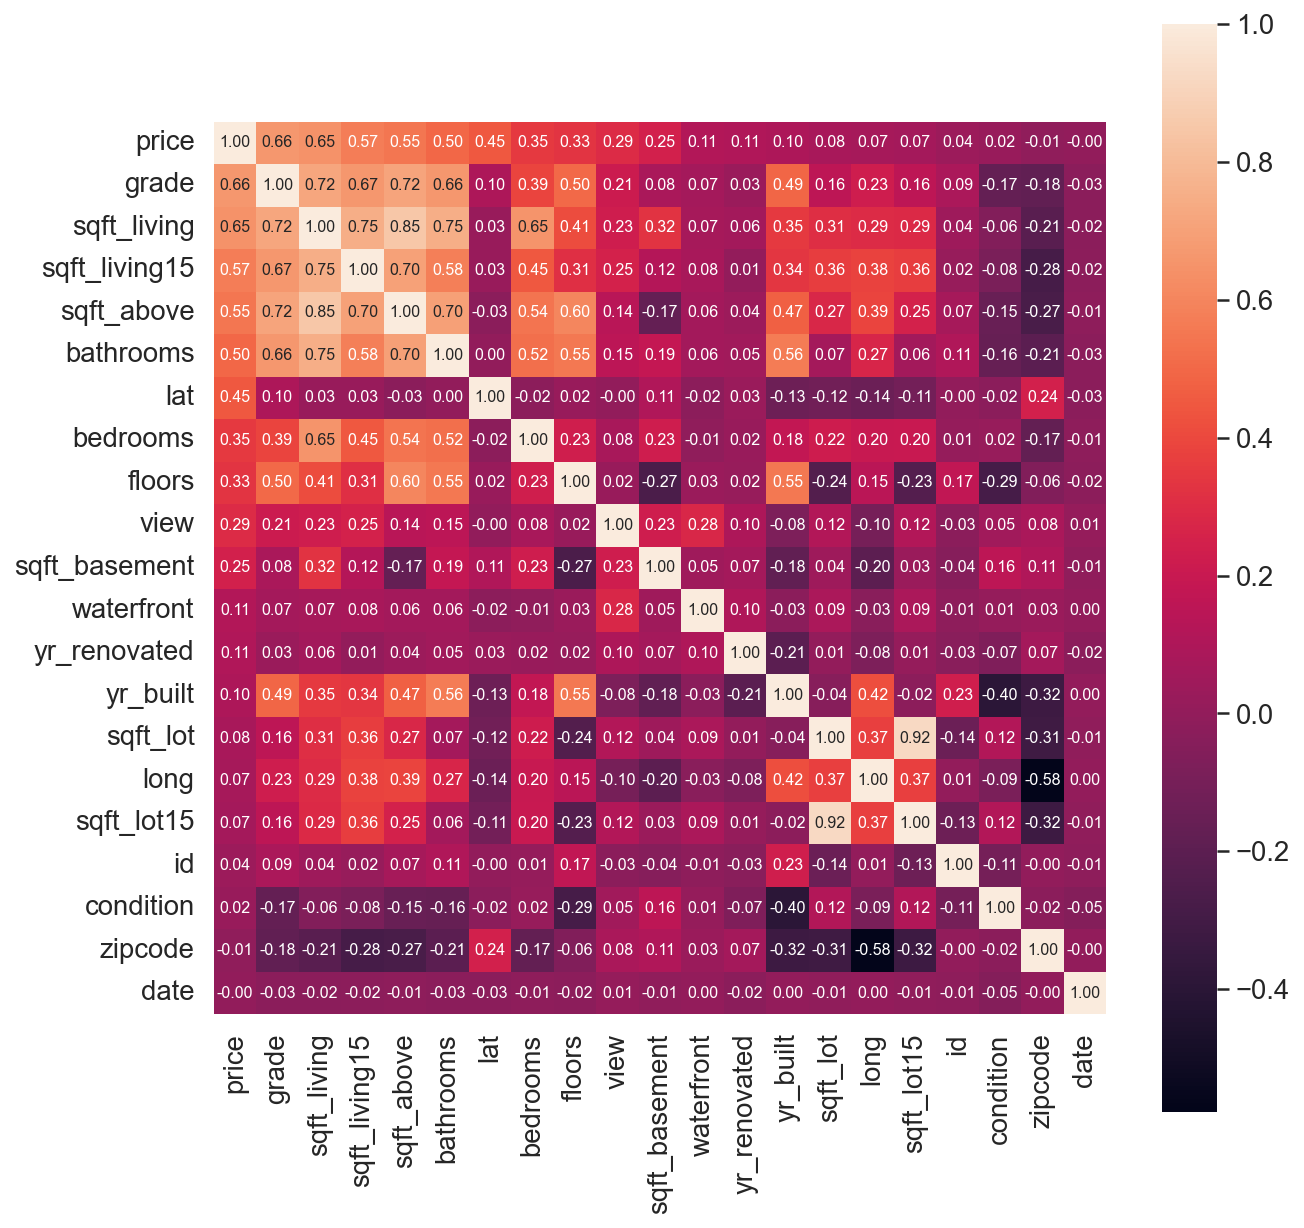

In [61]:
# correlation이 높은 상위 n개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=len(train), columns='price').index # price과 correlation이 높은 column n개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [62]:
# price에 대한 상관관계 내림차순 정렬
train_corr["price"].sort_values(ascending = False)

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
view             0.291720
sqft_basement    0.245304
waterfront       0.113179
yr_renovated     0.112381
yr_built         0.097844
sqft_lot         0.080554
long             0.071757
sqft_lot15       0.065771
id               0.036892
condition        0.021520
date            -0.001679
zipcode         -0.009266
Name: price, dtype: float64

- 피어슨 상관계수 해석 방법
  - -1 ~ 1 사이 값을 가짐
  - r 값은 x와 y가 완전히 동일하면 +1, 전혀 다르면 0, 반대방향으로 완전히 동일하면 -1의 값을 가짐
  - 양수일 때는 하나의 값이 증가할 때 다른 변수의 값도 증가하는 관계
  - 음수일 때는 하나의 값이 증가할 때 다른 변수의 값은 감소하는 관계

|r 값|관계|
|:---:|:---:|
|+0.7 ~ +1.0|강한 양적 상관관계|
|+0.3 ~ +1.7|약한 양적 상관관계|
|-0.1 ~ +0.1|상관관계 거의 없음|
|-0.7 ~ -0.3|약한 음적 상관관계|
|-1.0 ~ -0.7|강한 음적 상관관계|

=> 상관관계 값이 음의 값 or -0.1 ~ +0.1 범위인 컬럼 삭제

=> date, sqft_lot, condition, yr_built, zipcode, long, sqft_lot15 삭제

cf. Pearson 상관 계수는 선형 관계만 측정. Spearman 상관 계수는 단순 관계만 측정

cf. 상관계수가 0이어도 의미있는 관계가 존재할 수 있으니 산점도를 조사해서 관계 형태를 확인할 필요가 있다!

In [63]:
train_corr['price'] > 0.1

id               False
date             False
price             True
bedrooms          True
bathrooms         True
sqft_living       True
sqft_lot         False
floors            True
waterfront        True
view              True
condition        False
grade             True
sqft_above        True
sqft_basement     True
yr_built         False
yr_renovated      True
zipcode          False
lat               True
long             False
sqft_living15     True
sqft_lot15       False
Name: price, dtype: bool

In [64]:
del_column_list = ['date', 'sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15', 'waterfront', 'view', 'yr_renovated']

train = train.drop(del_column_list, axis=1)  # 컬럼 삭제

# train_data 에서 컬럼 삭제한 만큼 test_data 에서 컬럼 삭제해야 뒤에서 오류 안 남
test = test.drop(del_column_list, axis=1)  # 컬럼 삭제

In [65]:
# 컬럼 간 상관 계수 계산
train_corr = train.corr(method='spearman')

train_corr

id     price  bedrooms  bathrooms  sqft_living    floors  \
id             1.000000  0.036892  0.013834   0.111903     0.043499  0.173174   
price          0.036892  1.000000  0.350185   0.498989     0.646482  0.328674   
bedrooms       0.013834  0.350185  1.000000   0.523963     0.649001  0.233211   
bathrooms      0.111903  0.498989  0.523963   1.000000     0.748612  0.552080   
sqft_living    0.043499  0.646482  0.649001   0.748612     1.000000  0.408417   
floors         0.173174  0.328674  0.233211   0.552080     0.408417  1.000000   
grade          0.091820  0.662125  0.386833   0.661112     0.717800  0.504506   
sqft_above     0.072526  0.547868  0.540893   0.695672     0.846081  0.603085   
sqft_basement -0.043541  0.245304  0.229599   0.185469     0.322338 -0.268624   
lat           -0.001464  0.450692 -0.022815   0.000765     0.025544  0.024092   
sqft_living15  0.019945  0.573777  0.445933   0.575235     0.748214  0.311335   

                  grade  sqft_above  sqft_basement       lat  sqft_living15  
id             0.091820    0.072526      -0.043541 -0.001464       0.019945  
price          0.662125    0.547868       0.245304  0.450692       0.573777  
bedrooms       0.386833    0.540893       0.229599 -0.022815       0.445933  
bathrooms      0.661112    0.695672       0.185469  0.000765       0.575235  
sqft_living    0.717800    0.846081       0.322338  0.025544       0.748214  
floors         0.504506    0.603085      -0.268624  0.024092       0.311335  
grade          1.000000    0.715100       0.084636  0.100038       0.665039  
sqft_above     0.715100    1.000000      -0.167326 -0.028237       0.699158  
sqft_basement  0.084636   -0.167326       1.000000  0.111090       0.123785  
lat            0.100038   -0.028237       0.111090  1.000000       0.025154  
sqft_living15  0.665039    0.699158       0.123785  0.025154       1.000000

In [66]:
# price에 대한 상관관계 내림차순 정렬
train_corr["price"].sort_values(ascending = False)

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
sqft_basement    0.245304
id               0.036892
Name: price, dtype: float64

- price 와 correlation이 높은 순서대로 column 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'sqft_basement' 'id']


<AxesSubplot:>

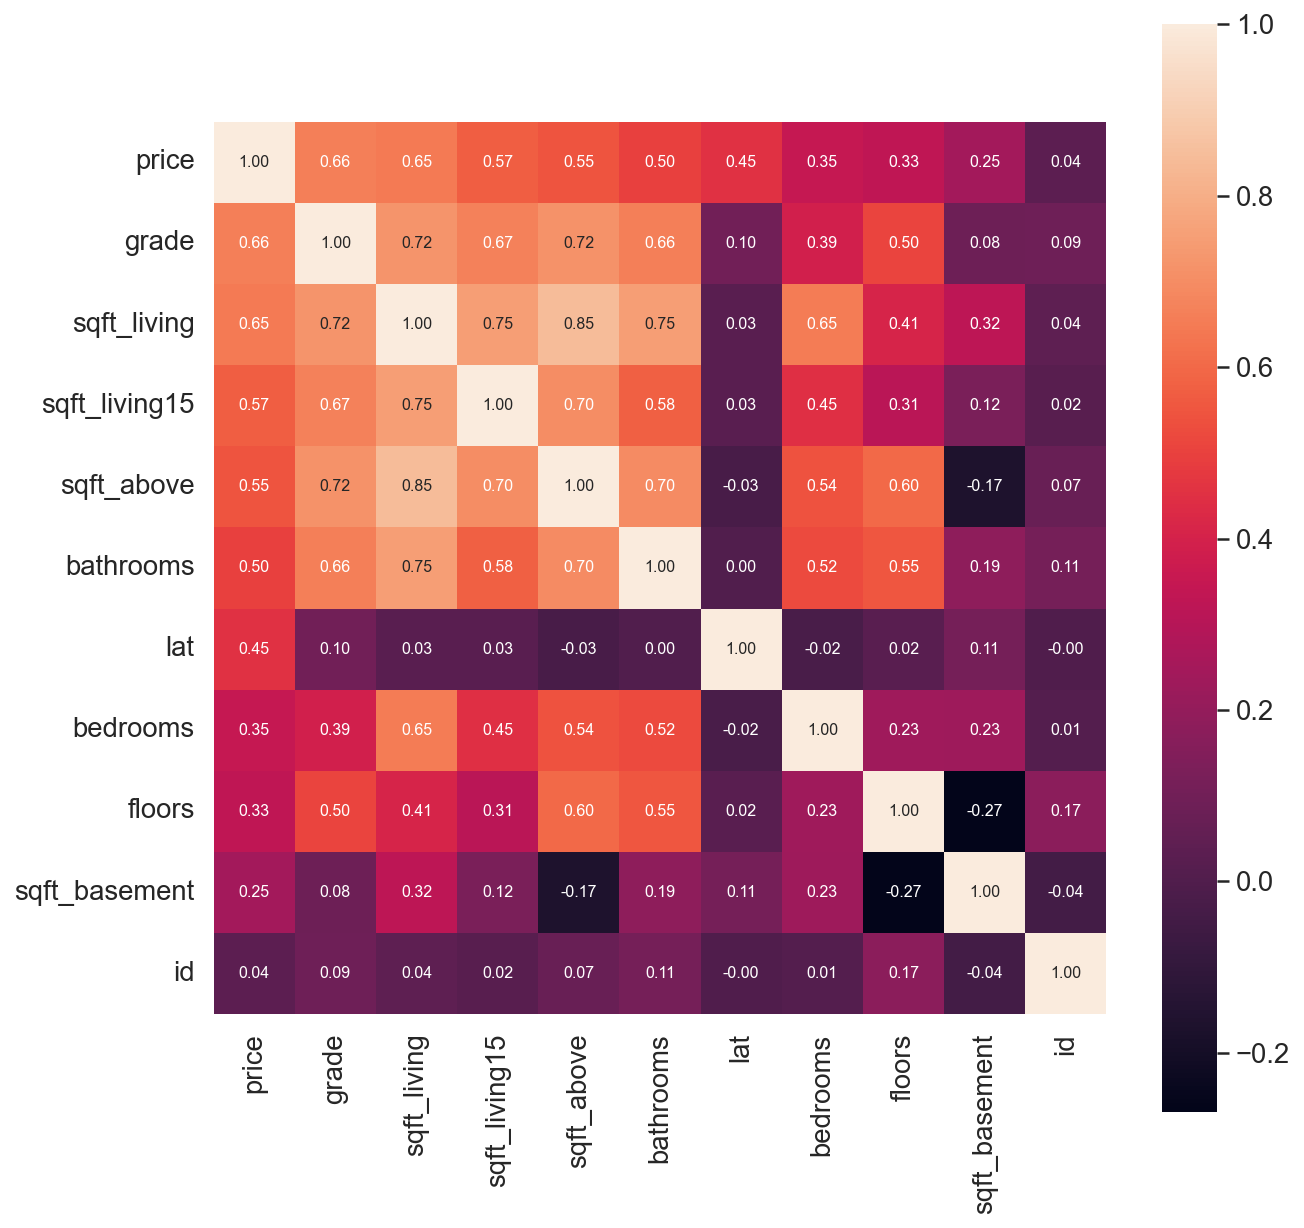

In [67]:
# correlation이 높은 상위 n개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=len(train), columns='price').index # price과 correlation이 높은 column n개(price 때문에 11로 설정한 것) 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 모든 컬럼 이상치 제거

- IQR 사용

In [68]:
# IQR을 이용한 이상치 제거 함수
def remove_outlier_test(d_cp, column):
    # print('컬렴명: {}'.format(column))
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)

    iqr = (quan_75 - quan_25) * 1.5
    
    lowest = quan_25 - iqr
    highest= quan_75 + iqr
    
    outlier_index = fraud_column_data[(fraud_column_data<lowest) | (fraud_column_data>highest)].index
    # print('이상치 개수: {}'.format(len(outlier_index)))

    d_cp.drop(outlier_index, axis=0, inplace=True)
    # print('이상치 제거 후 데이터프레임: {}'.format(d_cp.shape))

    print(f'* {column} 컬럼 이상치 {len(outlier_index)}개 제거 결과: {d_cp.shape}')

    return d_cp

In [69]:
for column in train:
    train = remove_outlier_test(train, column)

* id 컬럼 이상치 0개 제거 결과: (15035, 11)
* price 컬럼 이상치 240개 제거 결과: (14795, 11)
* bedrooms 컬럼 이상치 340개 제거 결과: (14455, 11)
* bathrooms 컬럼 이상치 247개 제거 결과: (14208, 11)
* sqft_living 컬럼 이상치 18개 제거 결과: (14190, 11)
* floors 컬럼 이상치 0개 제거 결과: (14190, 11)
* grade 컬럼 이상치 933개 제거 결과: (13257, 11)
* sqft_above 컬럼 이상치 3개 제거 결과: (13254, 11)
* sqft_basement 컬럼 이상치 0개 제거 결과: (13254, 11)
* lat 컬럼 이상치 0개 제거 결과: (13254, 11)
* sqft_living15 컬럼 이상치 30개 제거 결과: (13224, 11)


### 모든 컬럼 시각화

In [70]:
# 그래프 그리기(데이터 시각화)
def draw_graph(x, y, data):
    # plt.subplots
    f, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

    fig = sns.boxplot(x=x, y=y, data=data)  # seaborn.boxplot()

    fig = sns.jointplot(data=data, x=x, y=y, kind="reg", color="m", height=8)  # seaborn.jointplot()

    plt.show()

- grade 컬럼

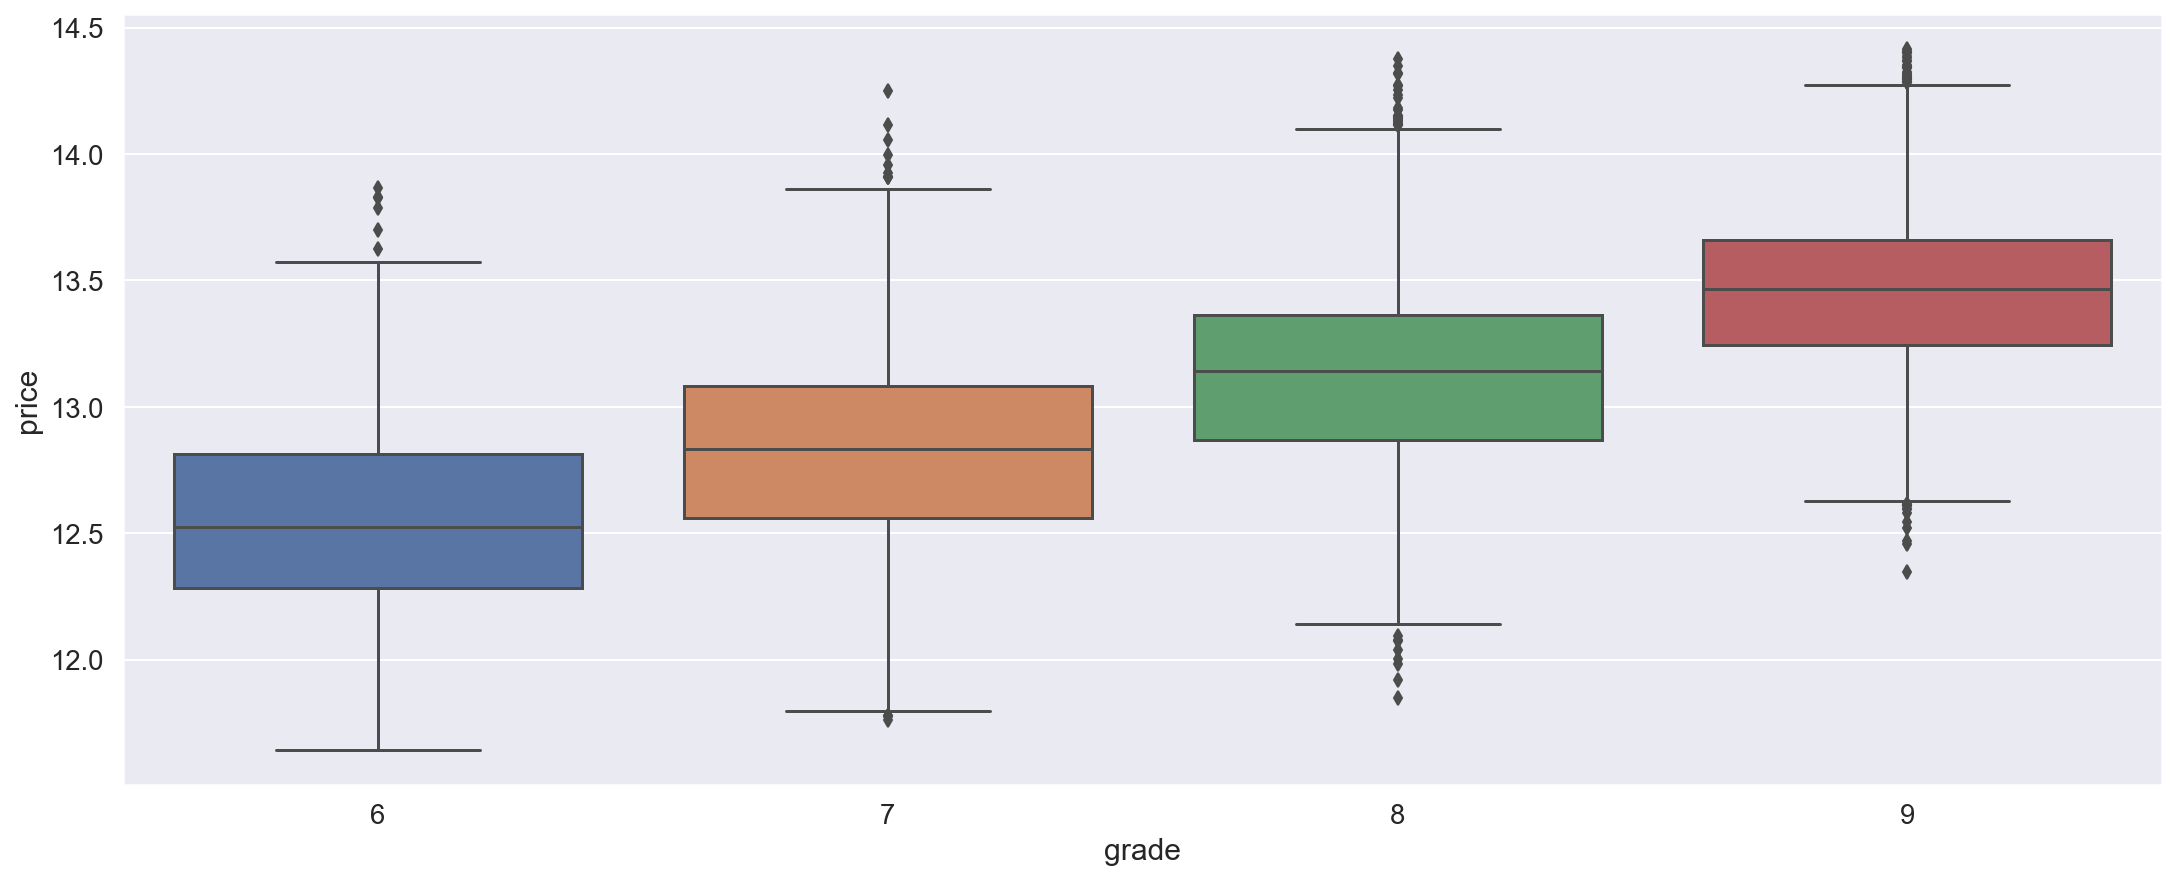

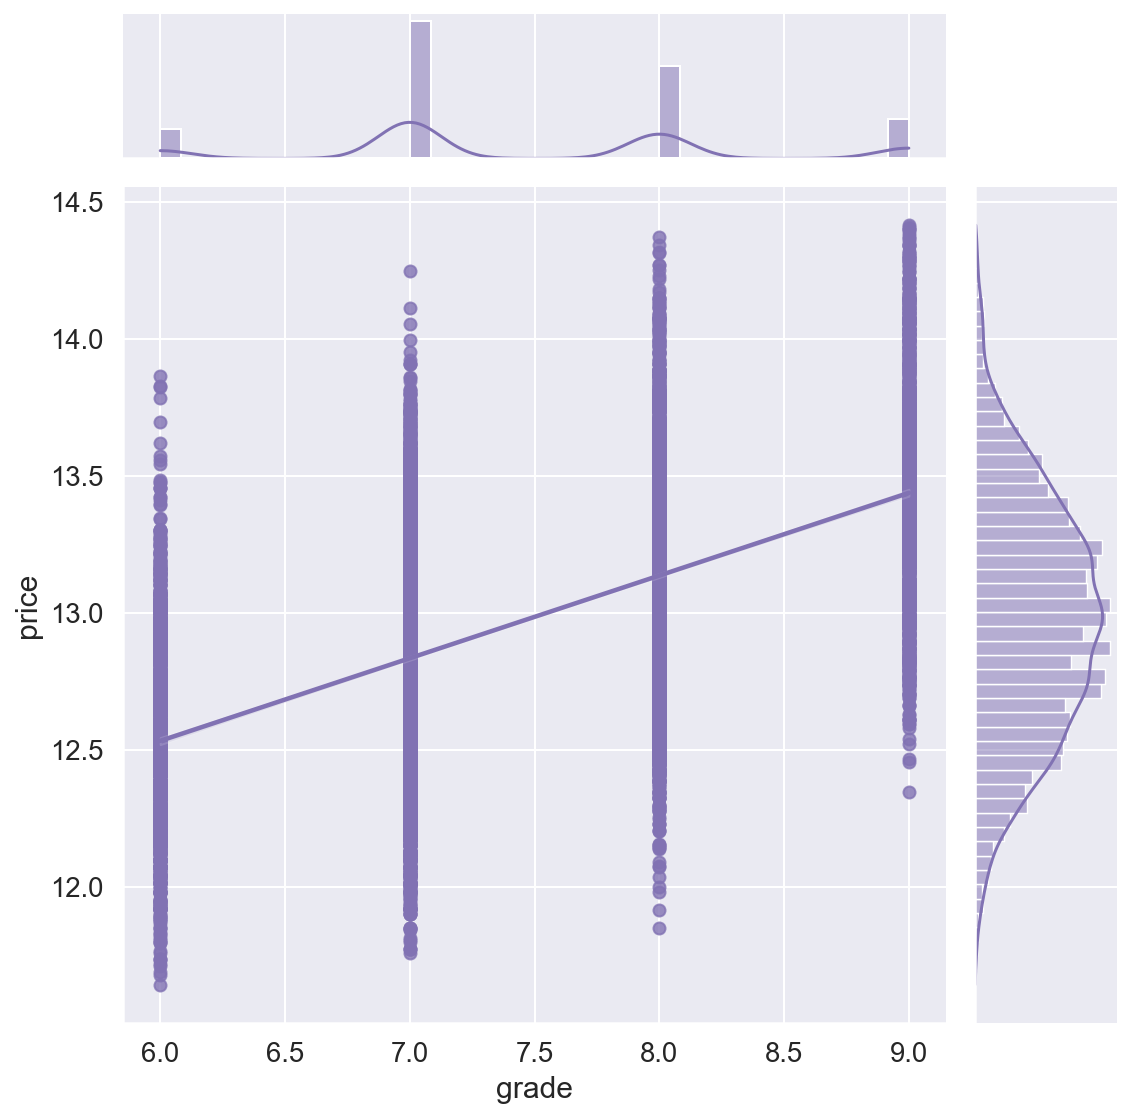

In [71]:
price_n_grade = pd.concat([train['price'], train['grade']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("grade", "price", price_n_grade)

- sqft_living 컬럼

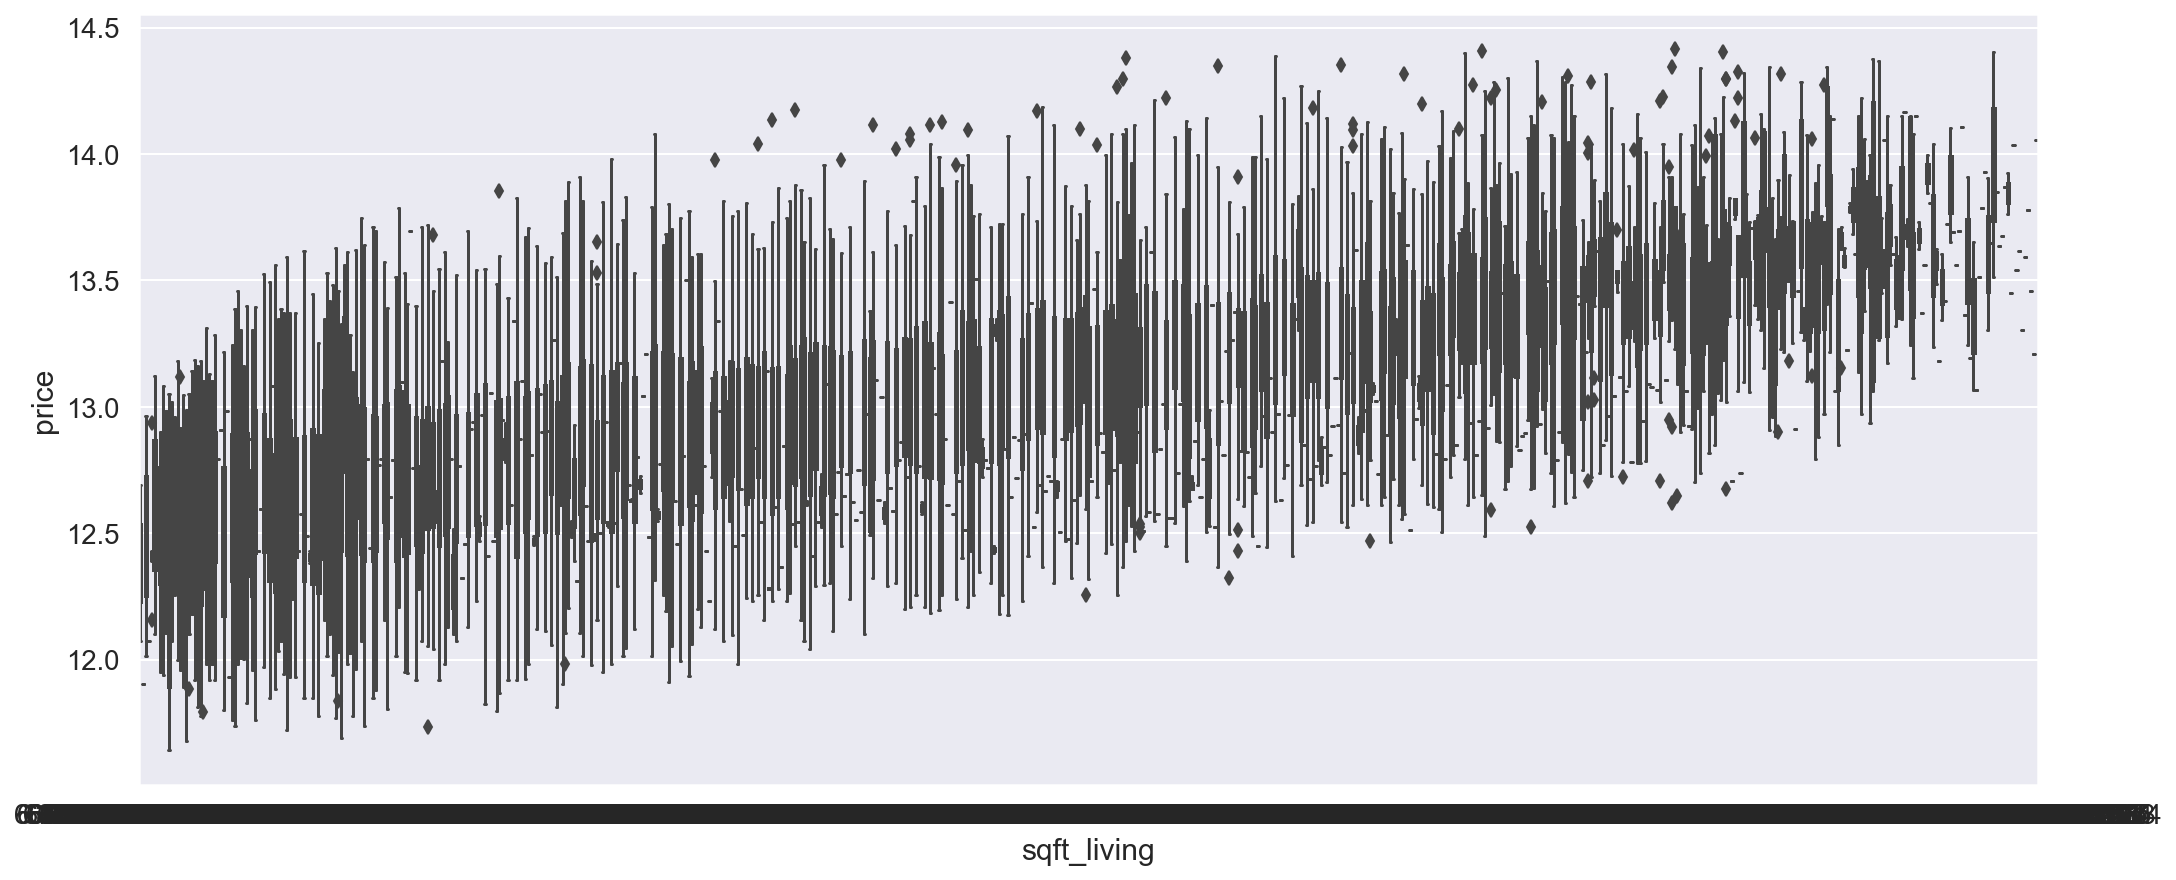

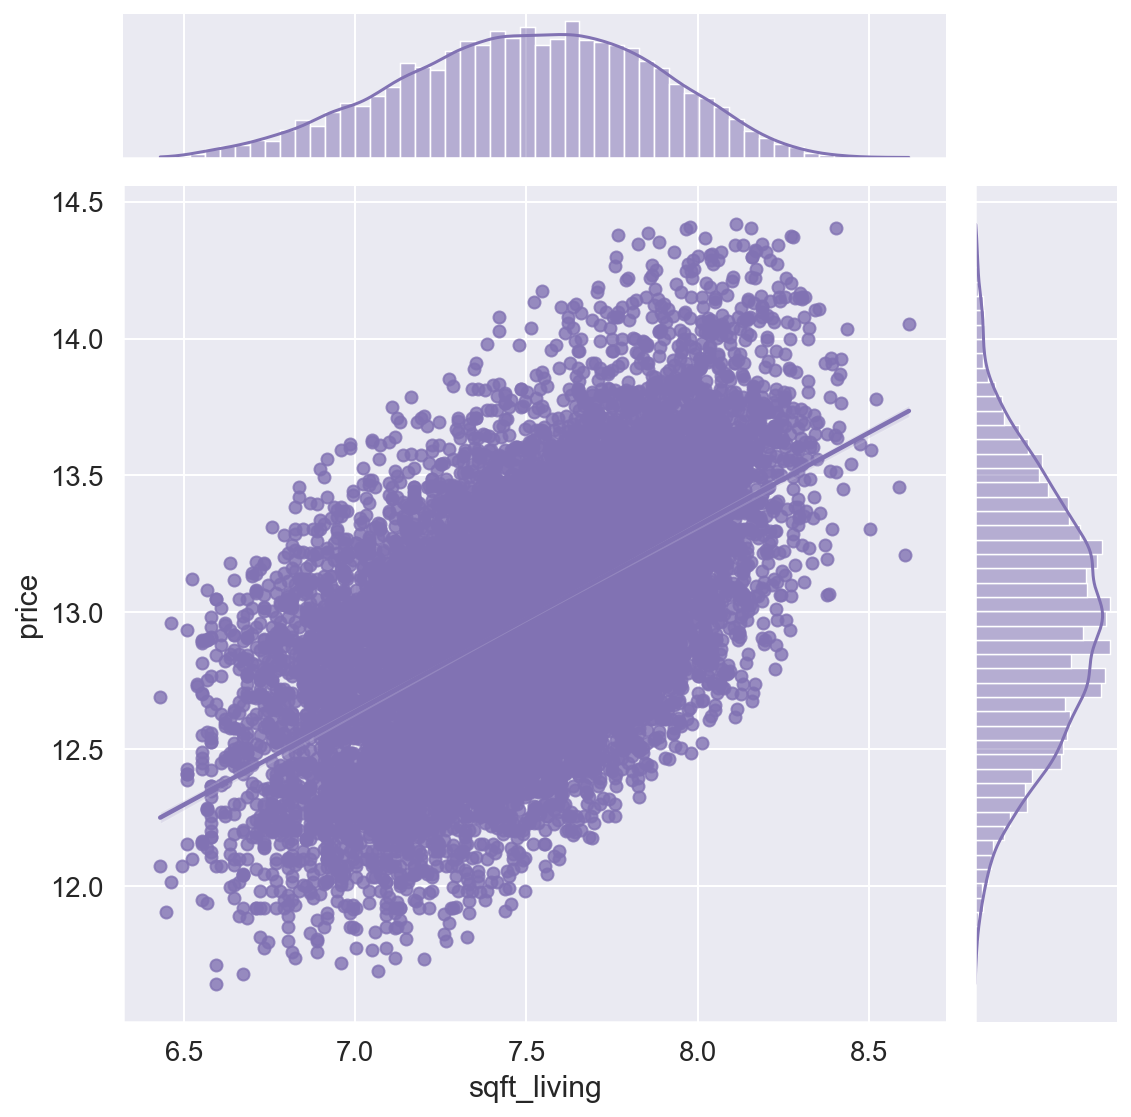

In [72]:
price_n_sqft_living = pd.concat([train['price'], train['sqft_living']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("sqft_living", "price", price_n_sqft_living)

- sqft_living15 컬럼

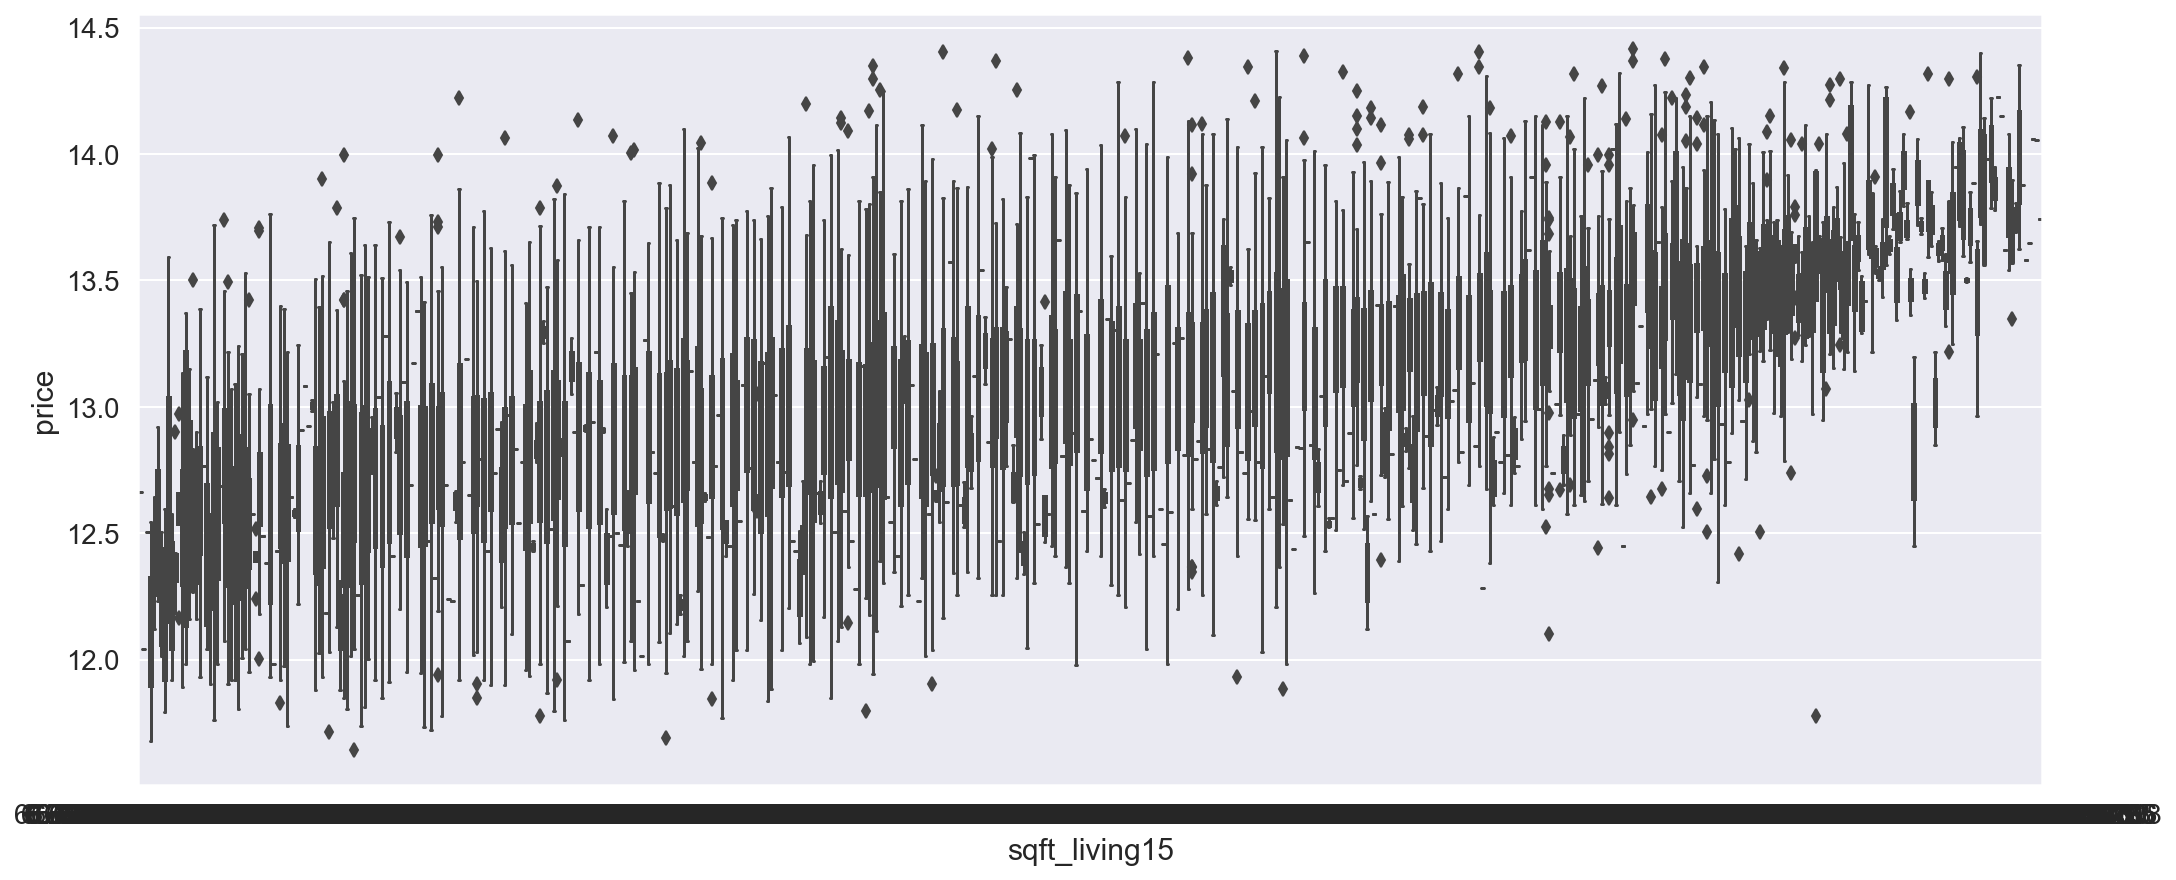

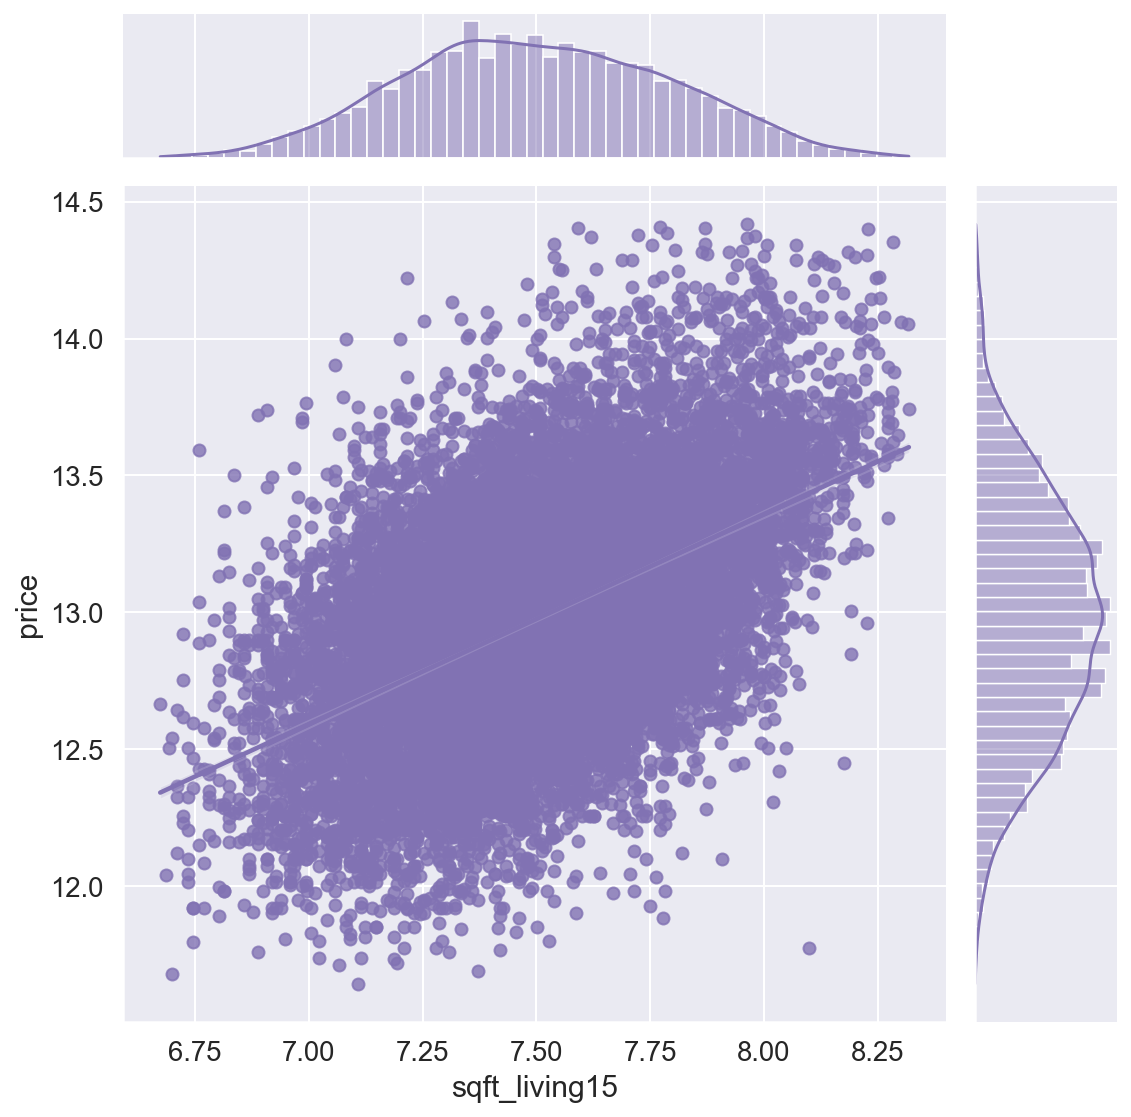

In [73]:
price_n_sqft_living15 = pd.concat([train['price'], train['sqft_living15']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("sqft_living15", "price", price_n_sqft_living15)

- sqft_above 컬럼

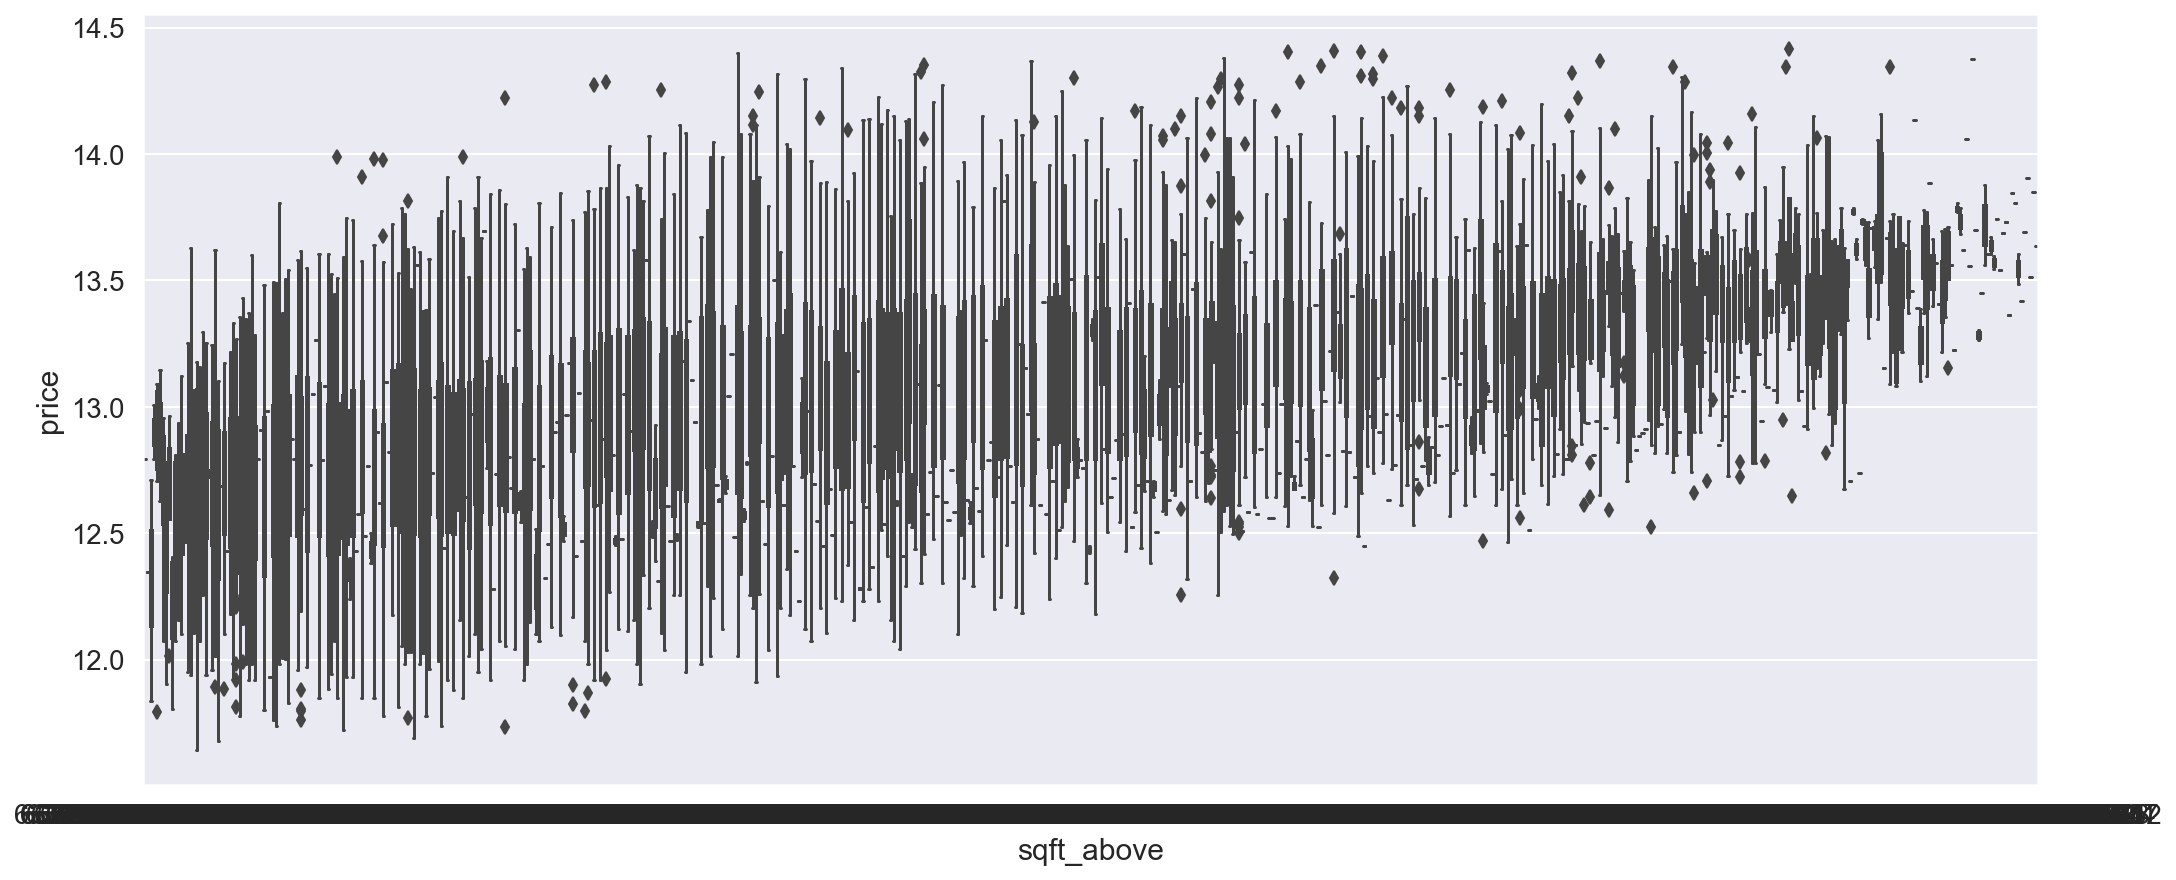

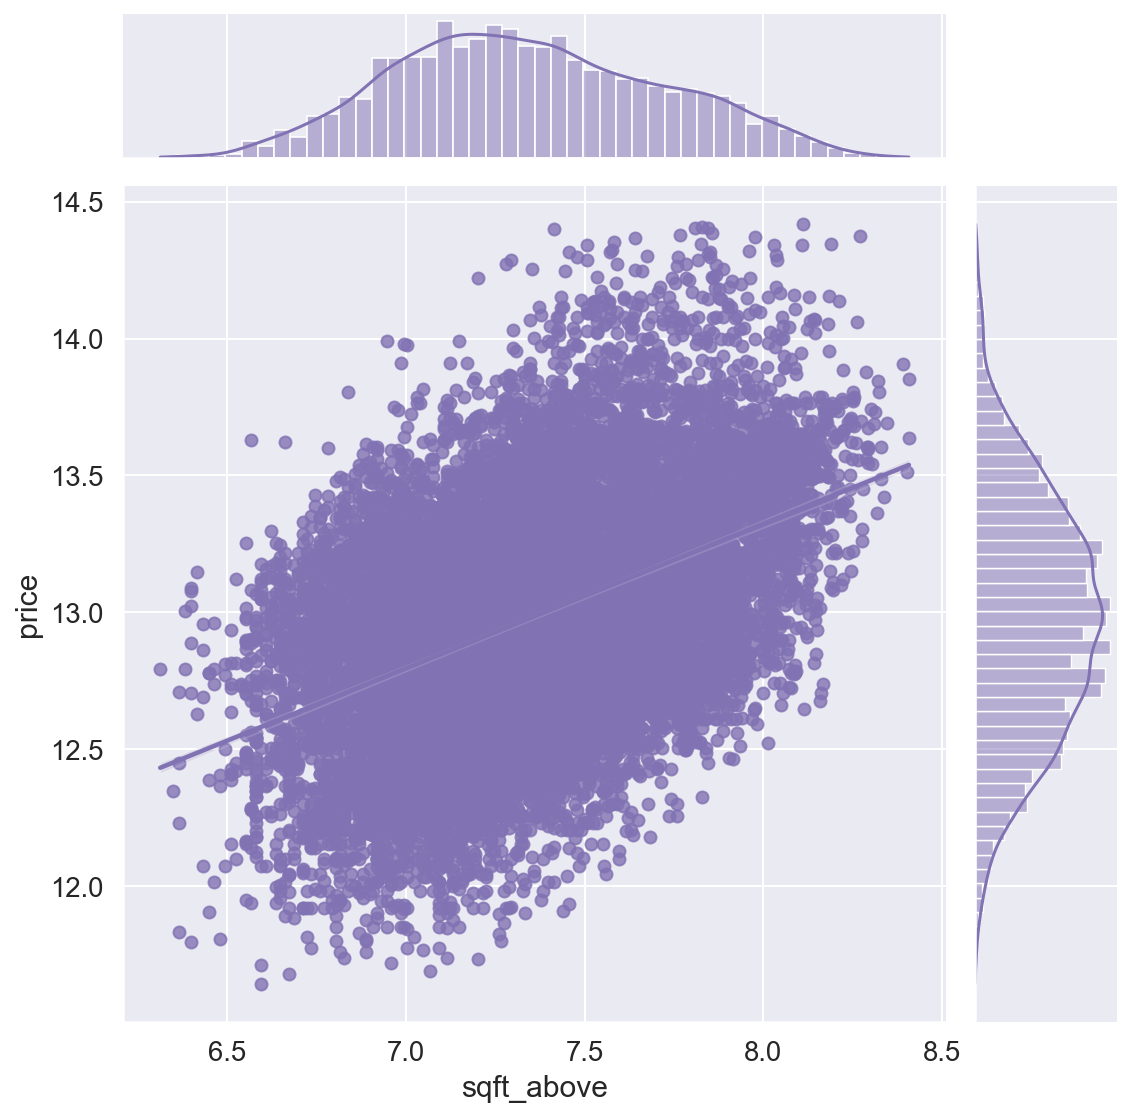

In [74]:
price_n_sqft_above = pd.concat([train['price'], train['sqft_above']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("sqft_above", "price", price_n_sqft_above)

- bathrooms 컬럼

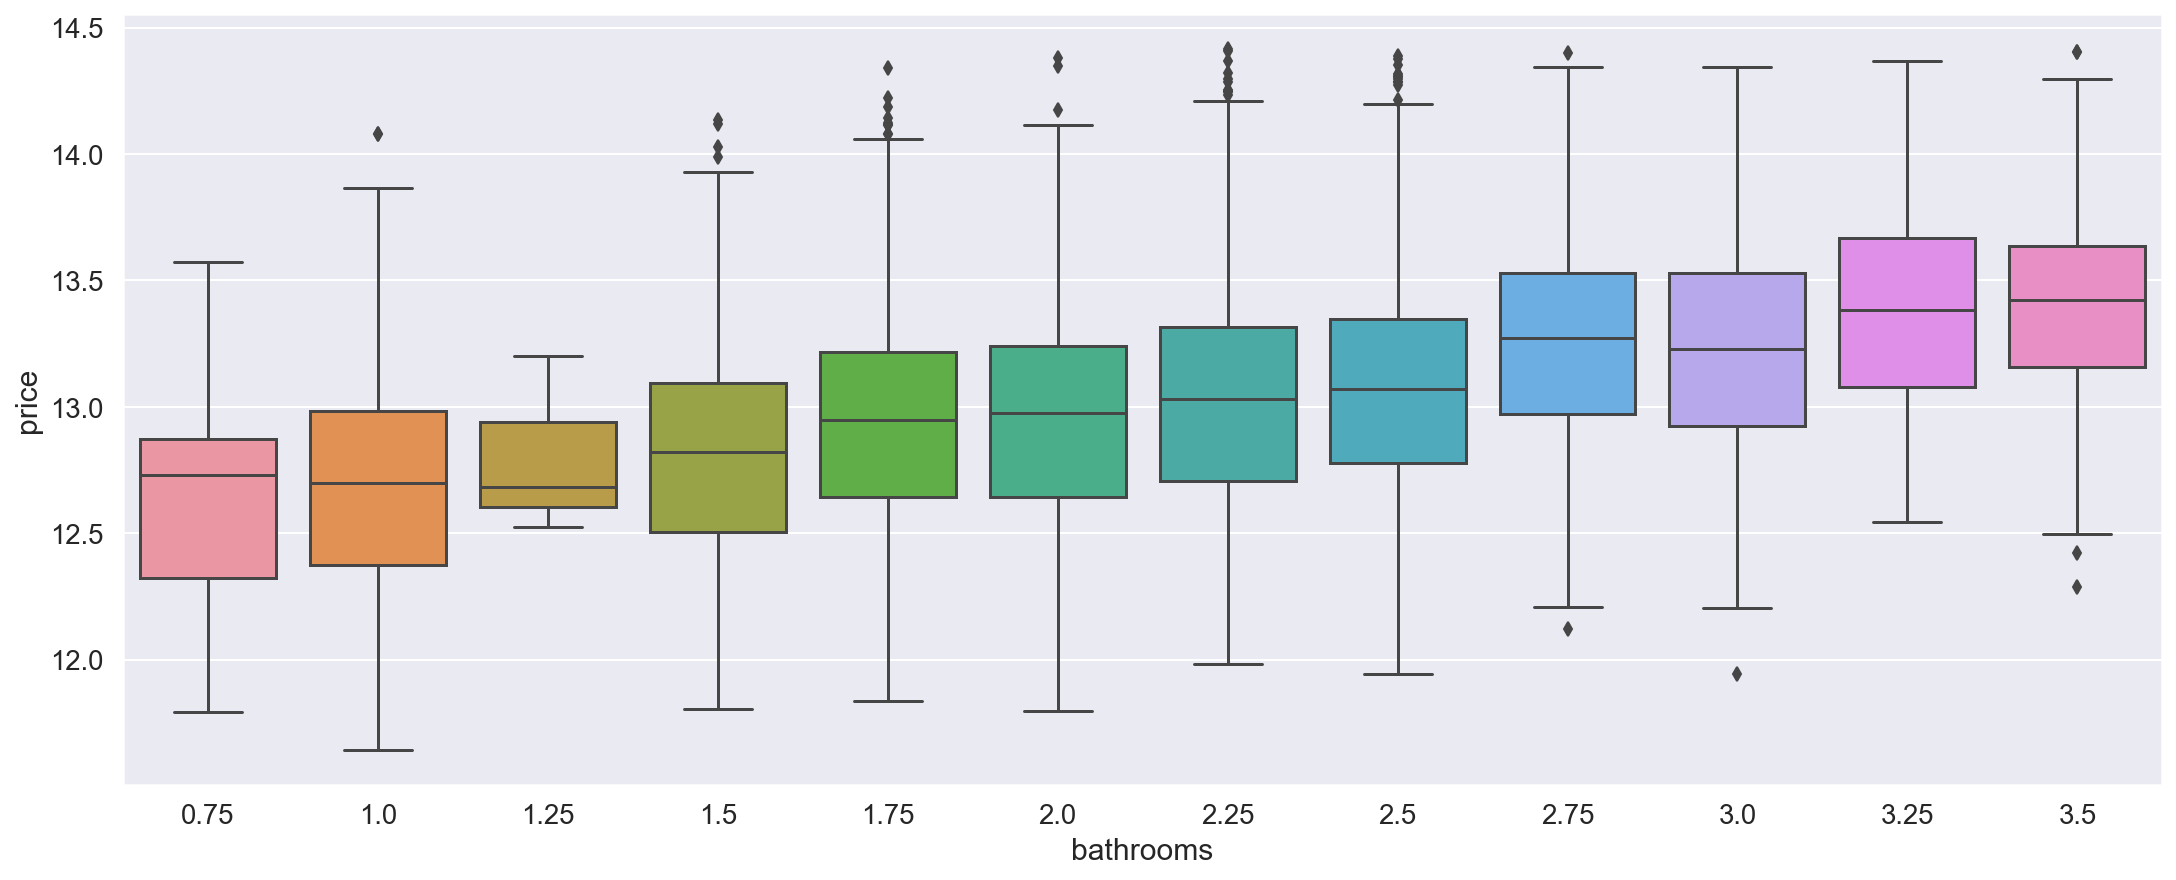

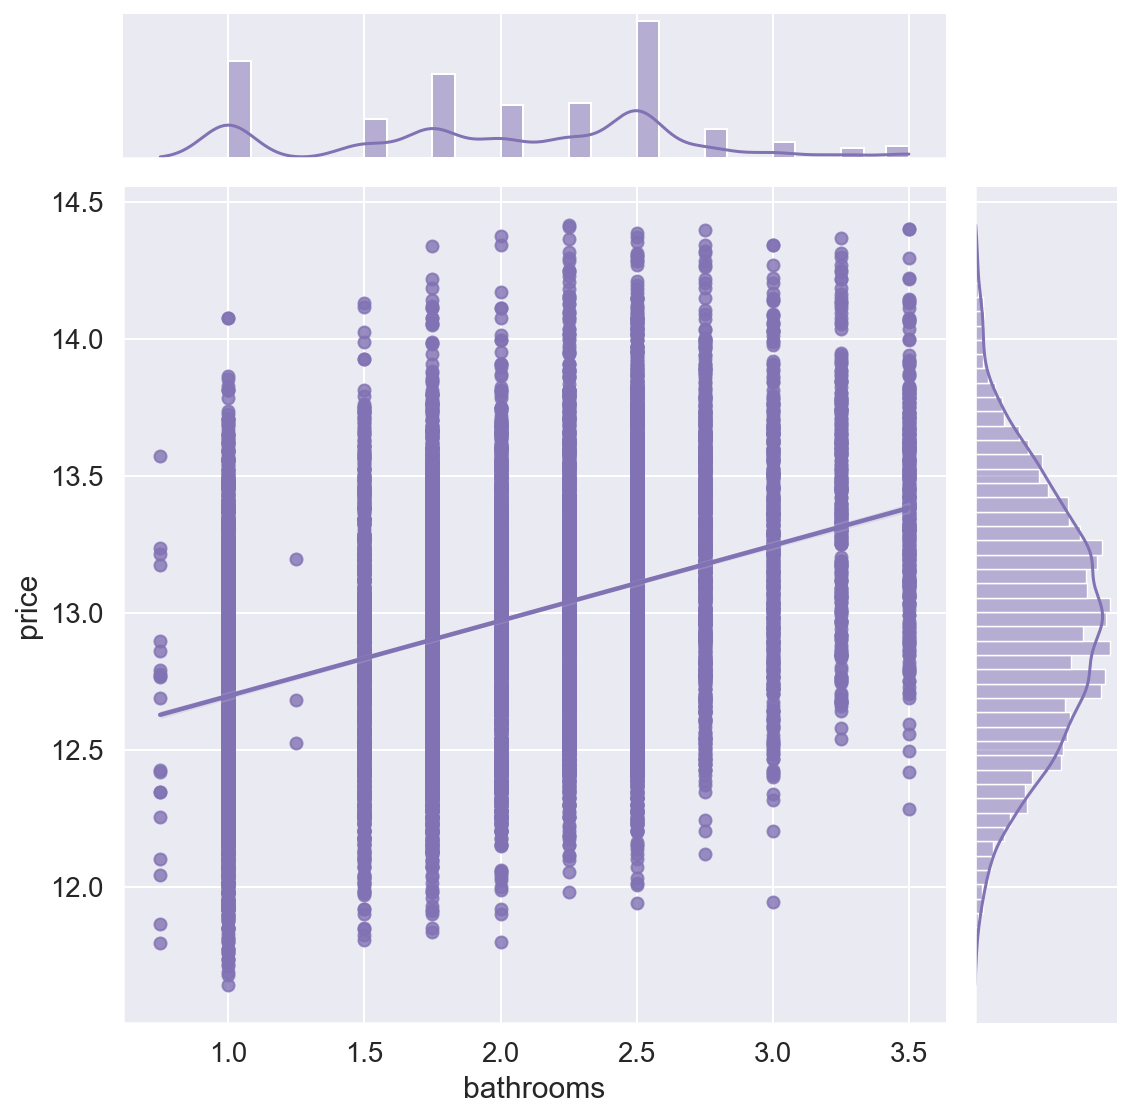

In [75]:
price_n_bathrooms = pd.concat([train['price'], train['bathrooms']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("bathrooms", "price", price_n_bathrooms)

- lat 컬럼

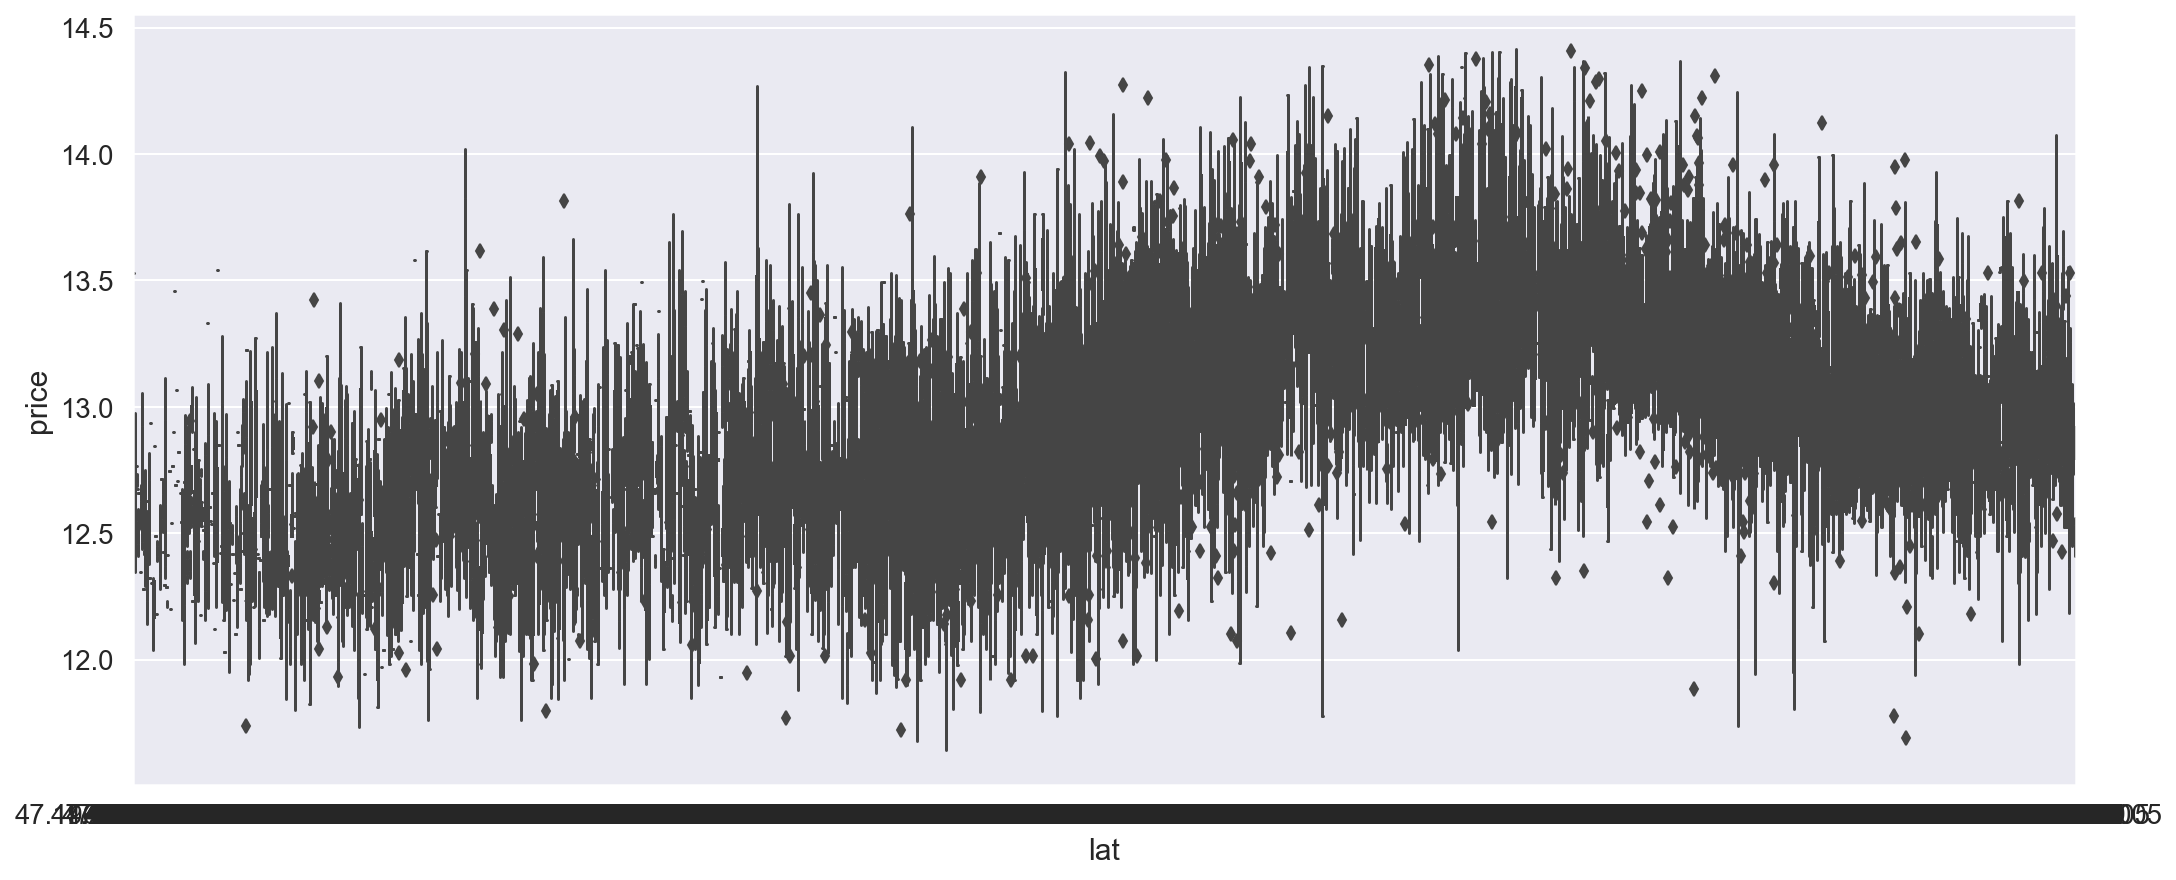

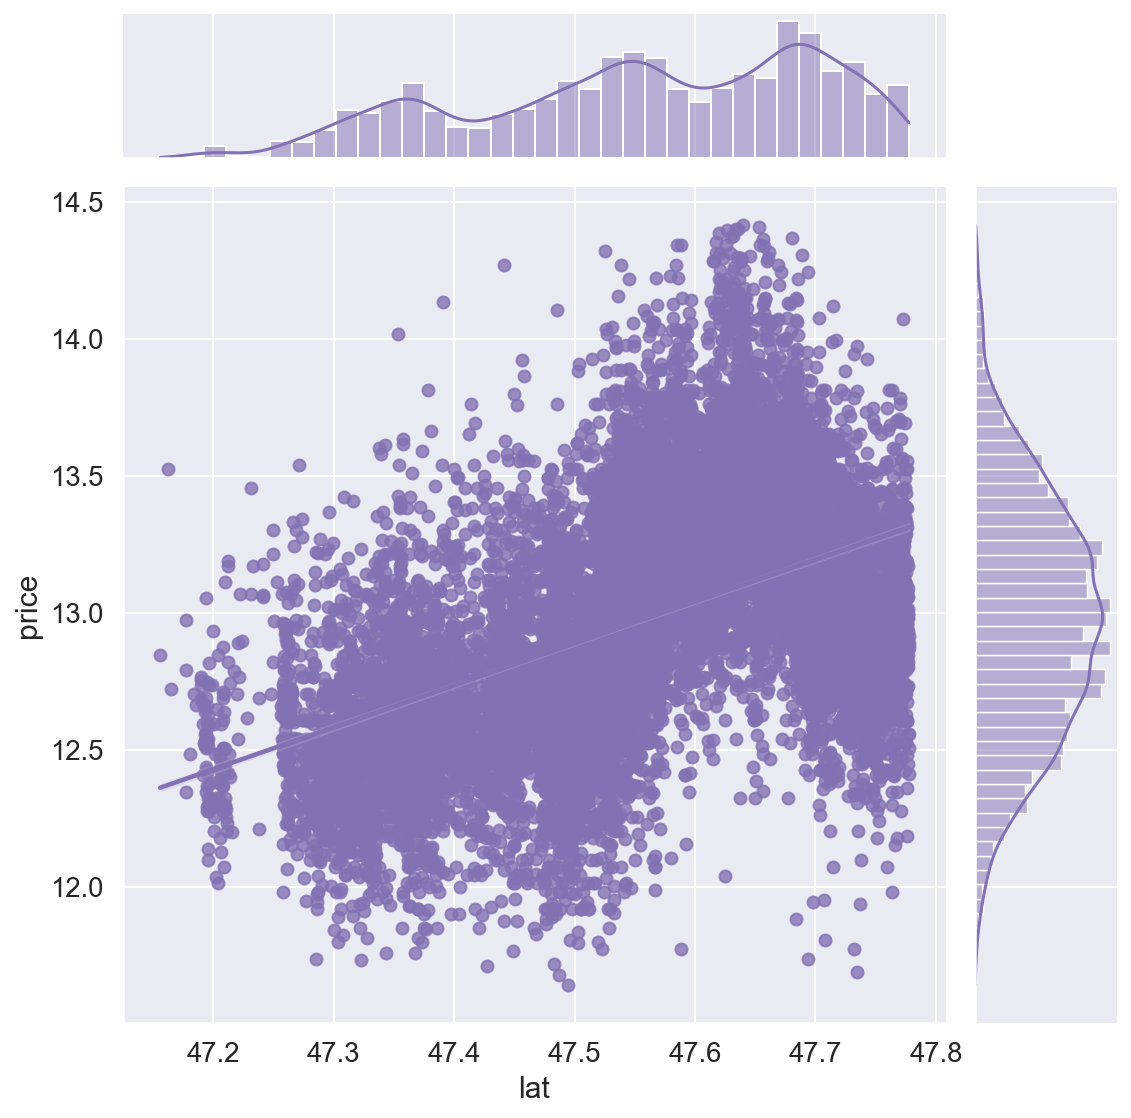

In [76]:
price_n_lat = pd.concat([train['price'], train['lat']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("lat", "price", price_n_lat)

- bedrooms 컬럼

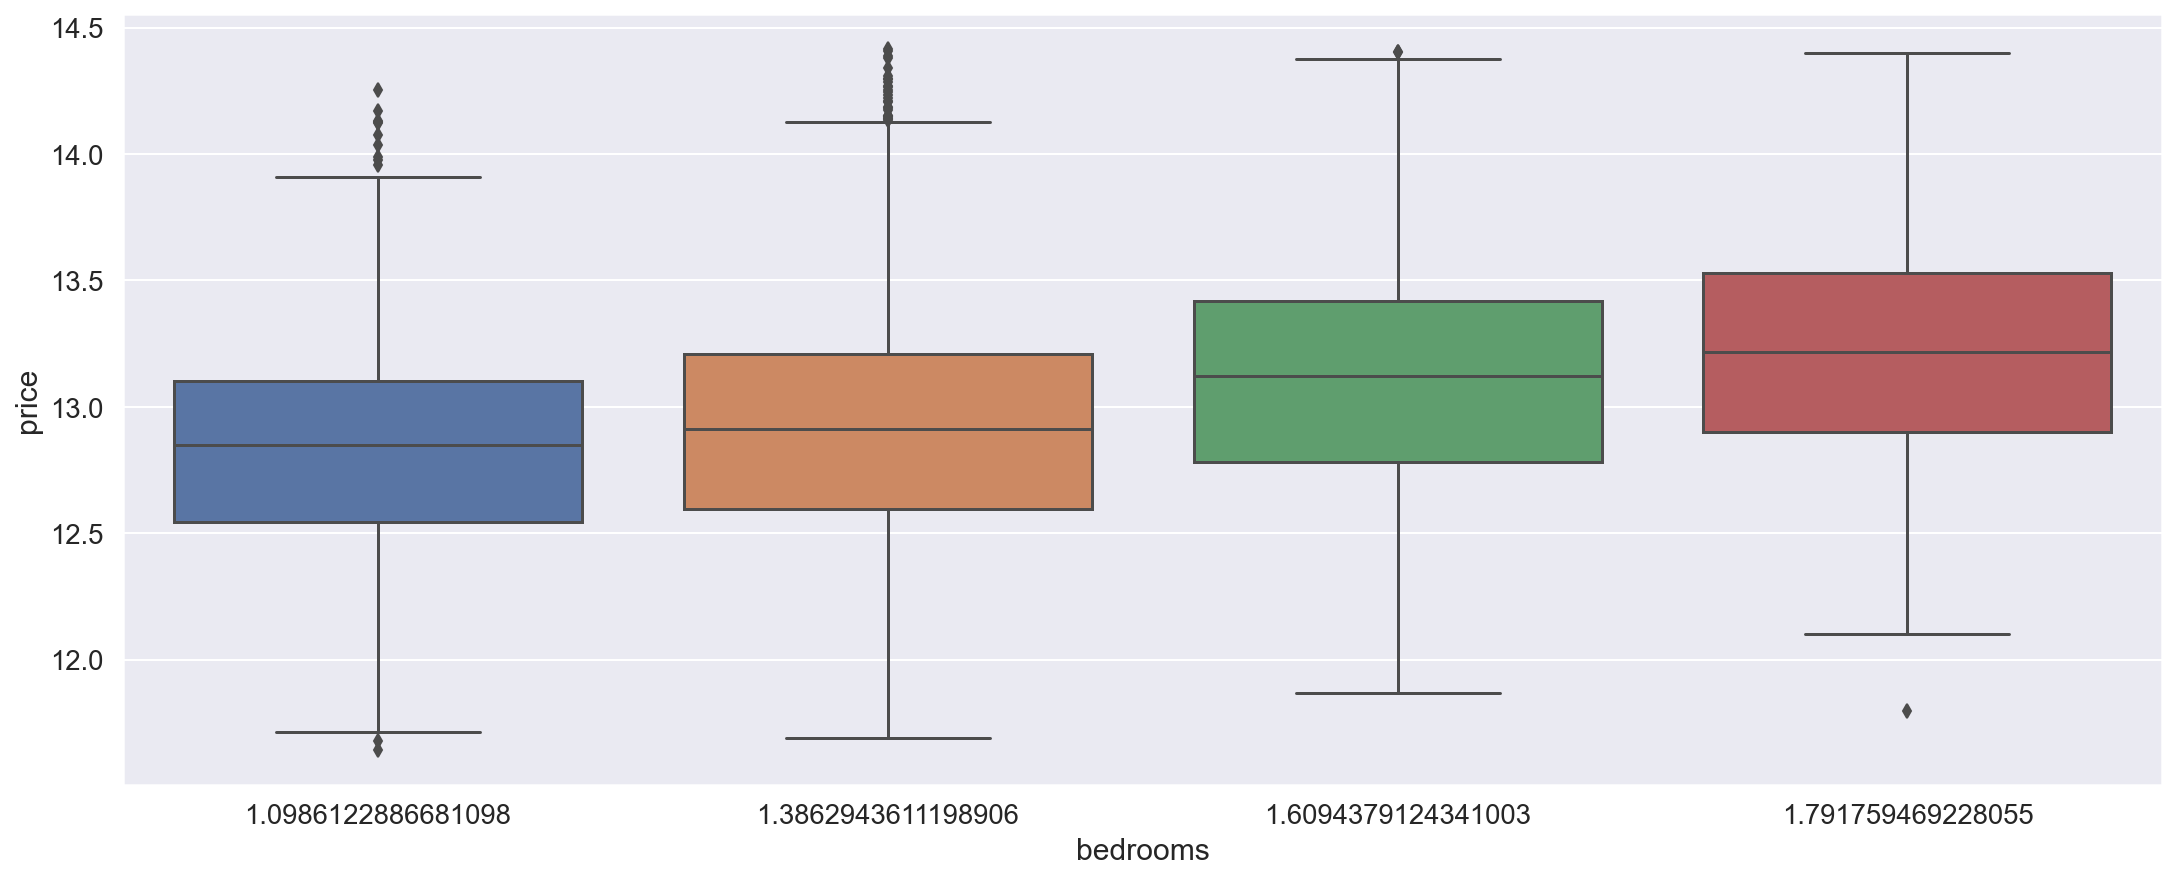

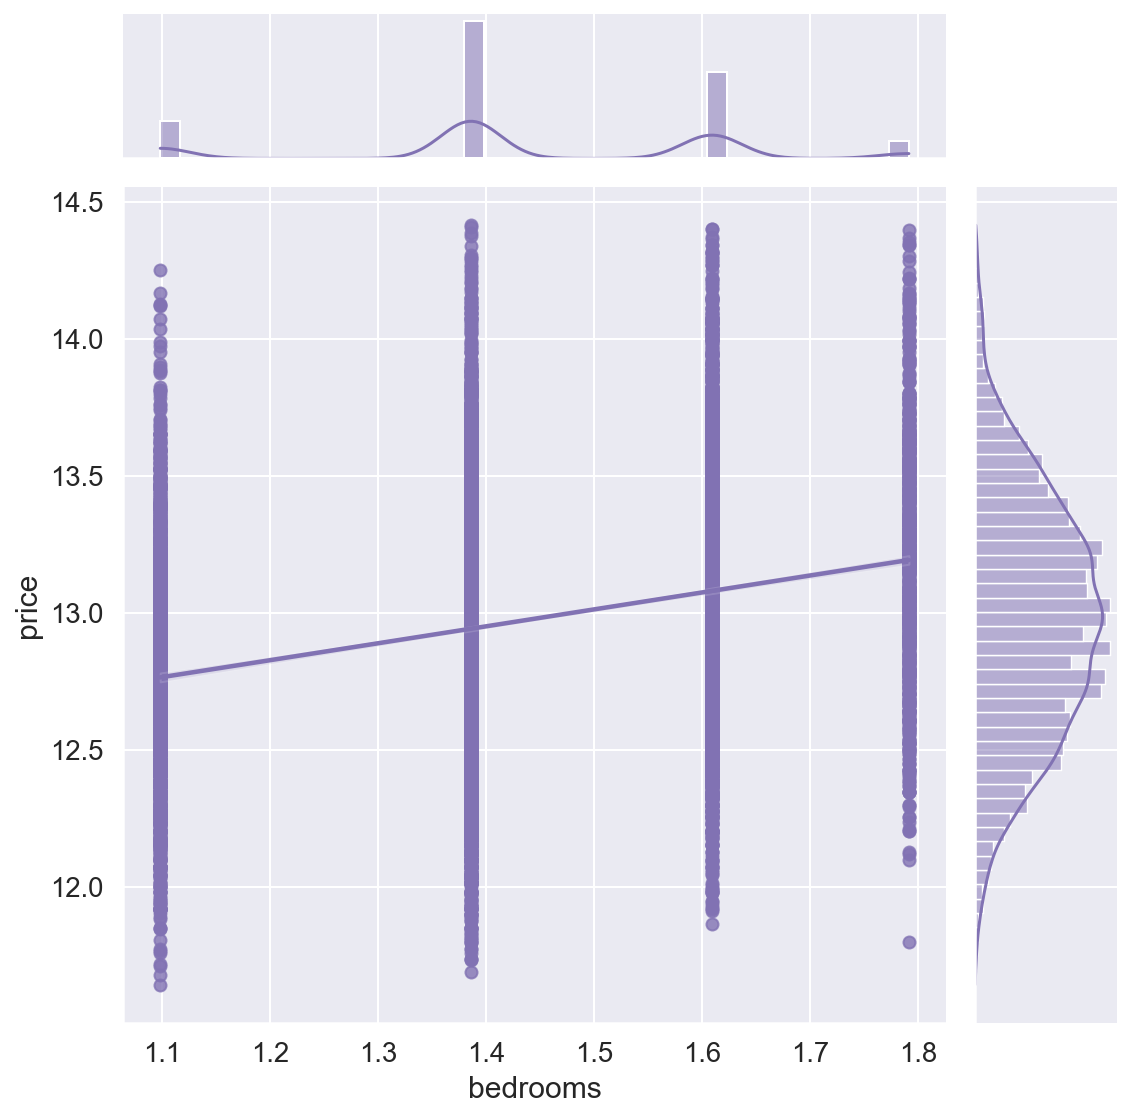

In [77]:
price_n_bedrooms = pd.concat([train['price'], train['bedrooms']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("bedrooms", "price", price_n_bedrooms)

- floors 컬럼

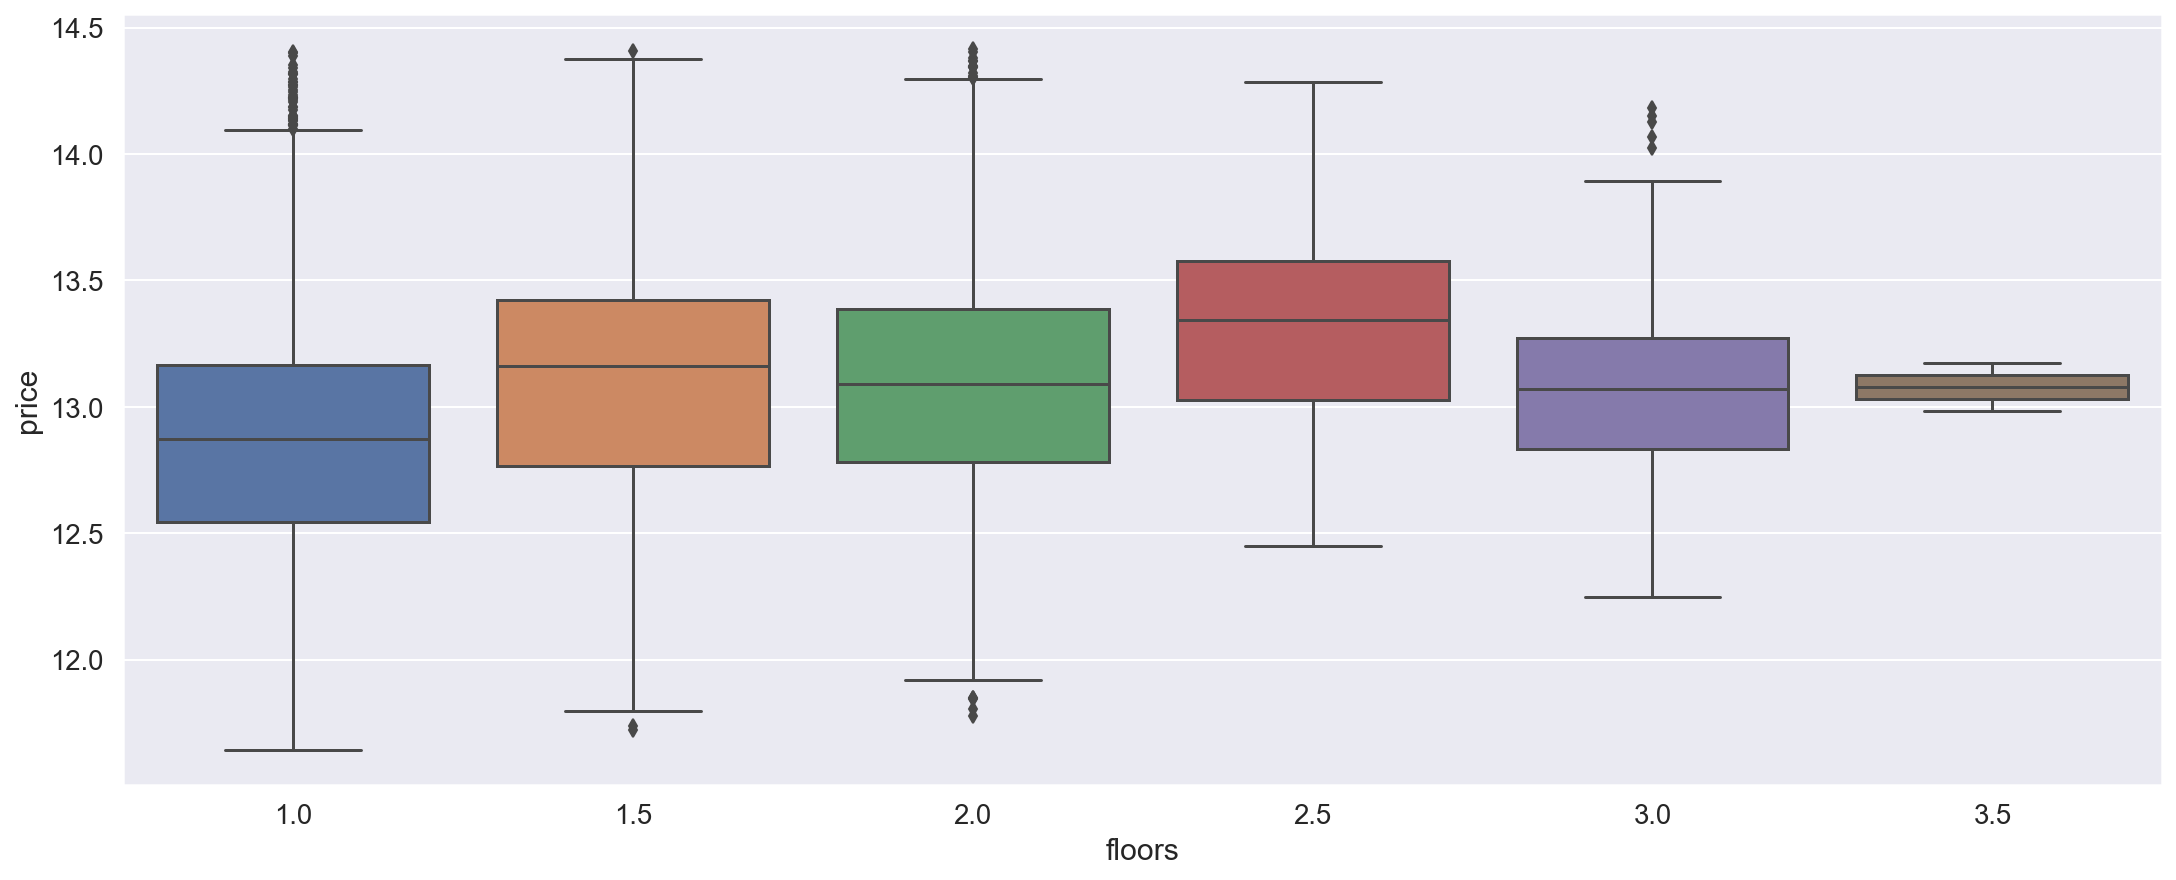

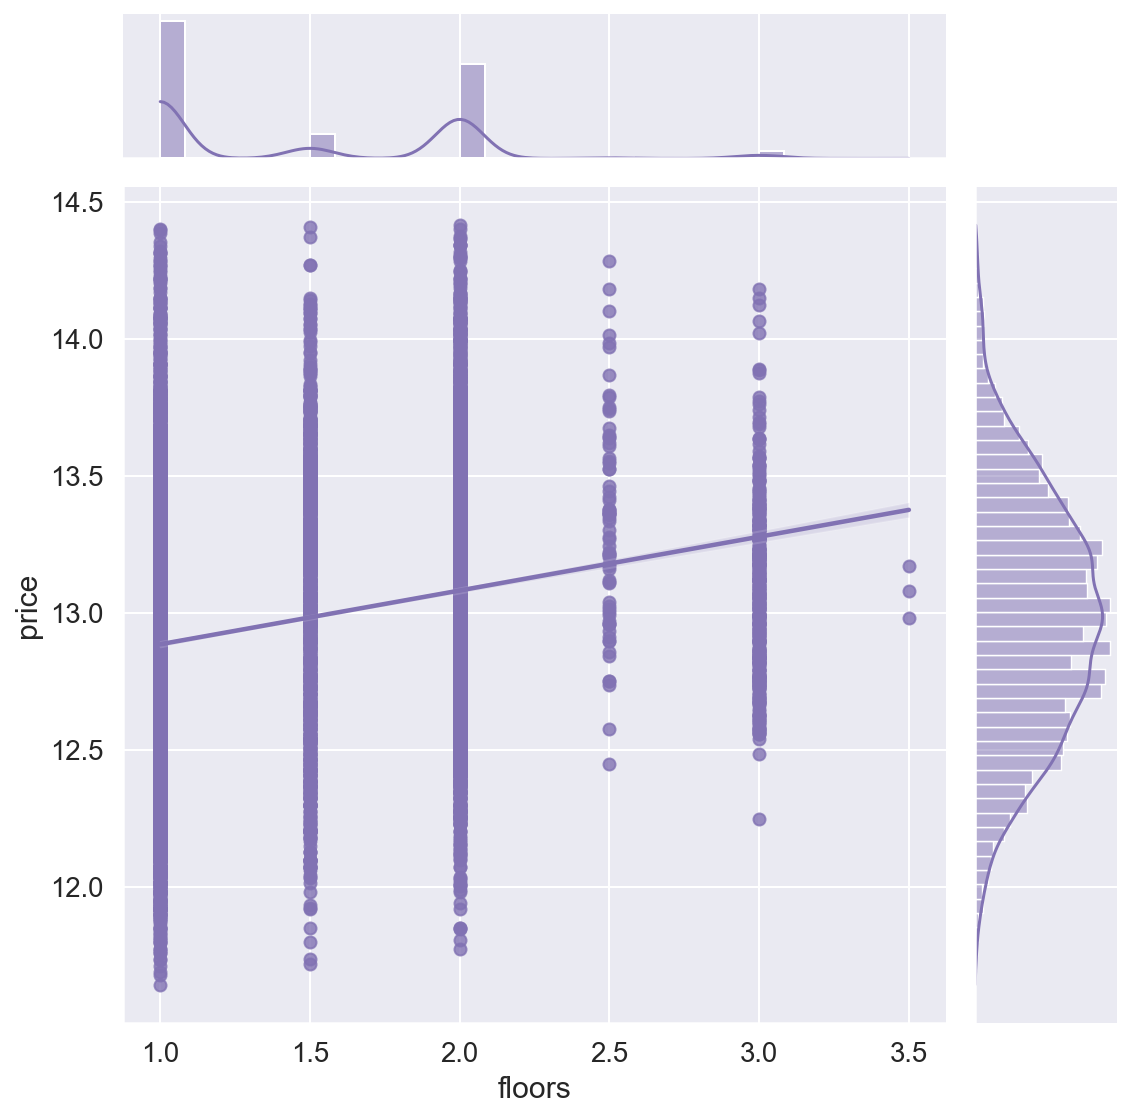

In [78]:
price_n_floors = pd.concat([train['price'], train['floors']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("floors", "price", price_n_floors)

- sqft_basement 컬럼

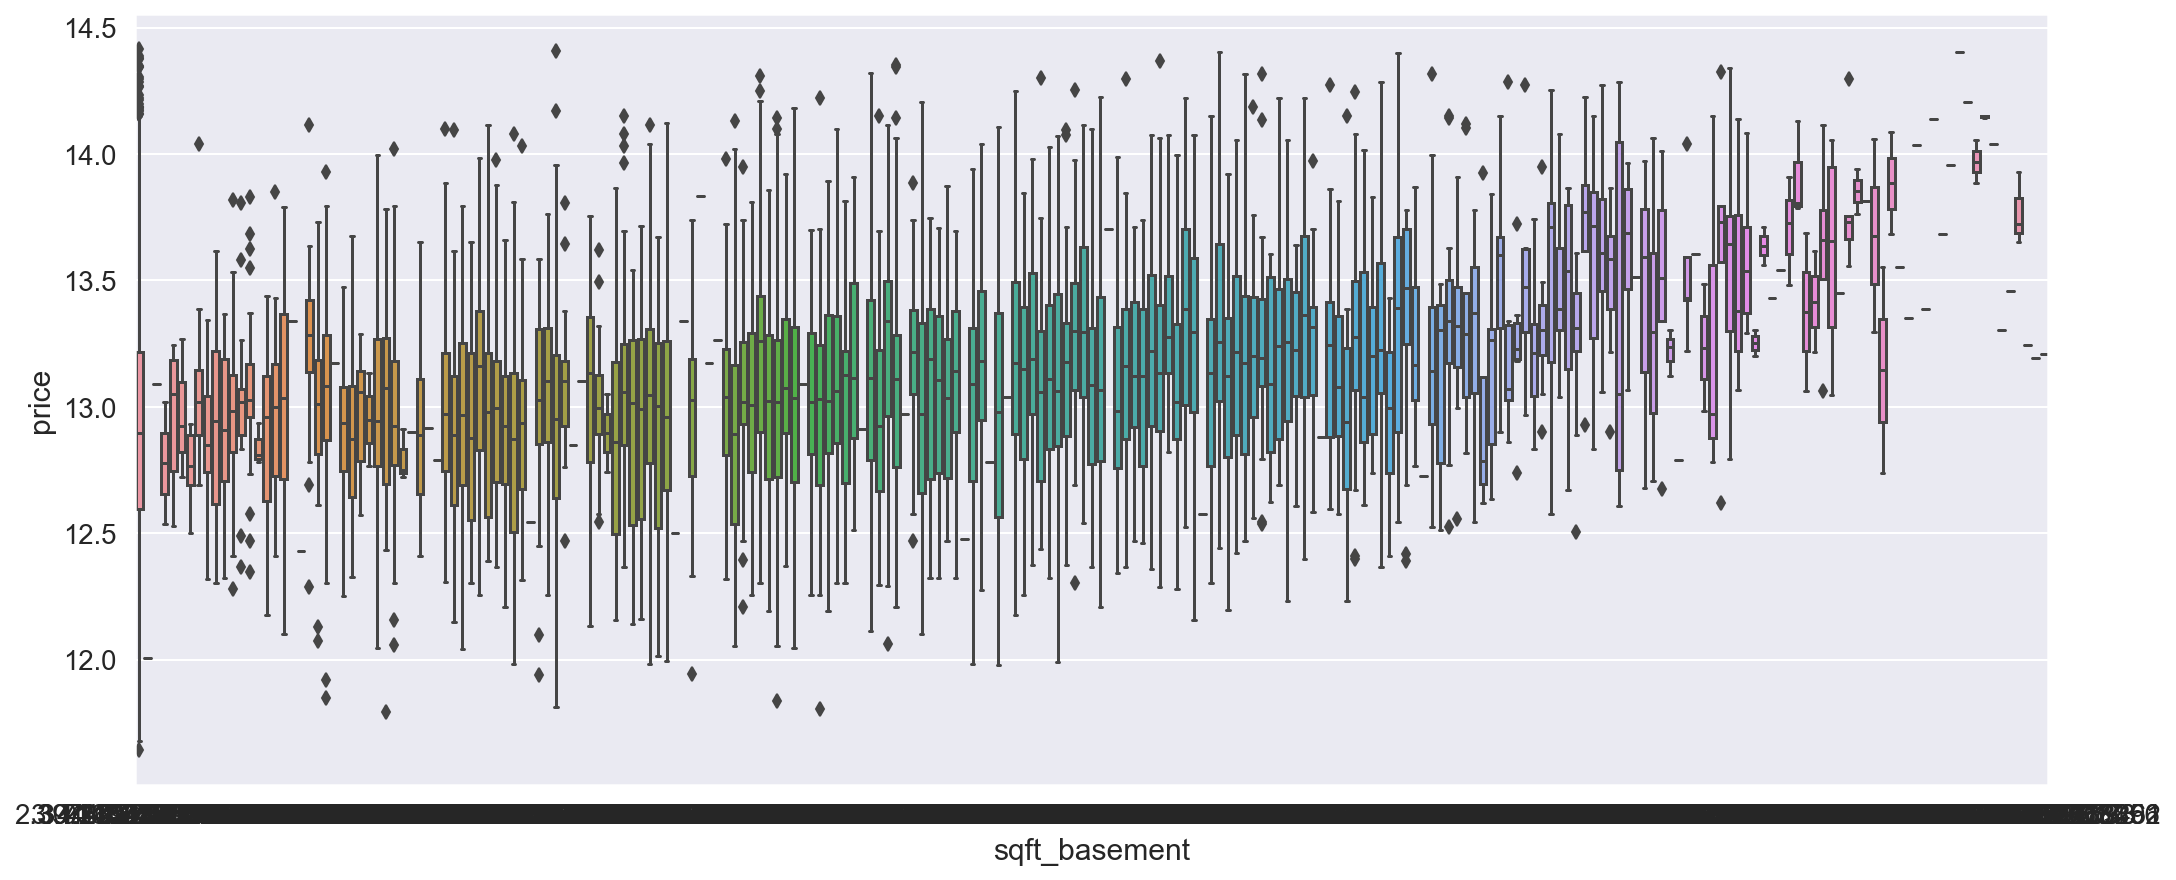

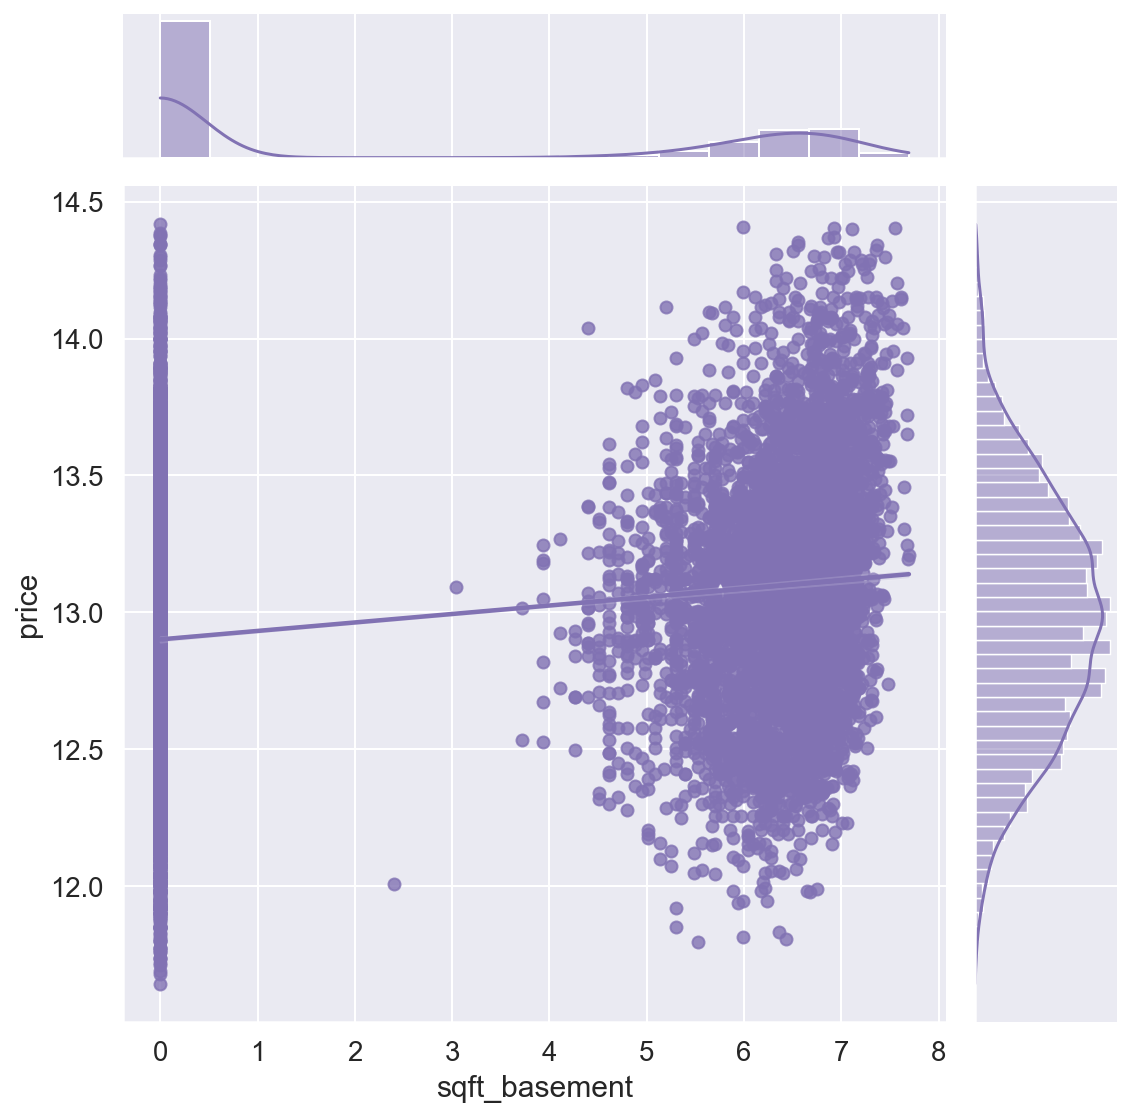

In [79]:
price_n_sqft_basement = pd.concat([train['price'], train['sqft_basement']], axis=1)

# 그래프 그리기(데이터 시각화)
draw_graph("sqft_basement", "price", price_n_sqft_basement)

### train 데이터에서 price 컬럼 삭제

In [80]:
y = train['price']

del train['price']  # price 컬럼 삭제

In [81]:
train_len = len(train)  # 13224
train_len

13224

In [82]:
sub_id = train['id']

del train['id']  # id 컬러 삭제

# train_data 에서 id 컬럼을 삭제했으니 test_data 에서 id 컬럼 삭제
del test['id']

In [83]:
sub_id

0            0
1            1
2            2
3            3
4            4
         ...  
15030    15030
15031    15031
15032    15032
15033    15033
15034    15034
Name: id, Length: 13224, dtype: int64

In [ ]:
print(train.shape)
print(test.shape)

In [85]:
# train과 test의 컬럼 개수가 맞는지 확인
print([column for column in train])
print([column for column in test])

['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']
['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']


## 3. 모델링

In [86]:
# RMSE 계산 함수
# y_test, y_pred는 np.log1p()로 변환된 값이므로 np.expm1()이 필요함
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# RMSE 구하는 함수(모델별 학습 및 예측)
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [87]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models_list =  [gboost, xgboost, lightgbm, rdforest]

In [88]:
get_scores(models_list, train, y)

RMSE
XGBRegressor               112554.100707
GradientBoostingRegressor  112532.285095
LGBMRegressor              109930.310554
RandomForestRegressor      109498.735105

- RMSE 값이 낮은 순서(=성능 좋은 순서): RandomForestRegressor, LGBMRegressor, GradientBoostingRegresor, XGBRegressor
- 사용할 모델: RandomForestRegressor, LGBMRegressor

In [89]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):

    # 1. GridSearchCV 모델로 `model`을 초기화합니다.
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 2. 모델을 fitting 합니다.
    grid_model.fit(train, y)

    # 3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by='RMSLE')  # 컬럼 RMSLE 를 기준으로 오름차순

    return results

- RandomForestRegressor

In [90]:
# param_grid에 탐색할 RandomForestRegressor 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [500, 600],
    'max_depth': [11, 13, 15],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


max_depth  min_samples_leaf  min_samples_split  n_estimators     score  \
12         11                18                  8           500 -0.042581   
16         11                18                 20           500 -0.042581   
14         11                18                 16           500 -0.042581   
13         11                18                  8           600 -0.042574   
17         11                18                 20           600 -0.042574   
15         11                18                 16           600 -0.042574   
32         13                18                 16           500 -0.042487   
34         13                18                 20           500 -0.042487   
30         13                18                  8           500 -0.042487   
35         13                18                 20           600 -0.042482   
33         13                18                 16           600 -0.042482   
31         13                18                  8           600 -0.042482   
50         15                18                 16           500 -0.042474   
48         15                18                  8           500 -0.042474   
52         15                18                 20           500 -0.042474   
49         15                18                  8           600 -0.042468   
51         15                18                 16           600 -0.042468   
53         15                18                 20           600 -0.042468   
9          11                12                 16           600 -0.042156   
11         11                12                 20           600 -0.042156   
7          11                12                  8           600 -0.042156   
10         11                12                 20           500 -0.042150   
8          11                12                 16           500 -0.042150   
6          11                12                  8           500 -0.042150   
29         13                12                 20           600 -0.042018   
27         13                12                 16           600 -0.042018   
25         13                12                  8           600 -0.042018   
26         13                12                 16           500 -0.042010   
28         13                12                 20           500 -0.042010   
24         13                12                  8           500 -0.042010   
47         15                12                 20           600 -0.041991   
45         15                12                 16           600 -0.041991   
43         15                12                  8           600 -0.041991   
46         15                12                 20           500 -0.041983   
44         15                12                 16           500 -0.041983   
42         15                12                  8           500 -0.041983   
1          11                 8                  8           600 -0.041932   
3          11                 8                 16           600 -0.041932   
5          11                 8                 20           600 -0.041925   
2          11                 8                 16           500 -0.041923   
0          11                 8                  8           500 -0.041923   
4          11                 8                 20           500 -0.041919   
19         13                 8                  8           600 -0.041760   
21         13                 8                 16           600 -0.041760   
20         13                 8                 16           500 -0.041751   
18         13                 8                  8           500 -0.041751   
23         13                 8                 20           600 -0.041746   
22         13                 8                 20           500 -0.041740   
39         15                 8                 16           600 -0.041716   
37         15                 8                  8           600 -0.041716   
38         15             

- 입력한 파라미터 중 RandomForestRegressor 은 RMSE 값이 제일 작은 max_depth=15, min_samples_leaf=8, min_samples_split=20, n_estimators=500 의 성능이 제일 좋았다.

In [106]:
# RandomForestRegressor 모델 학습

model = RandomForestRegressor(max_depth=15, min_samples_leaf=8, min_samples_split=20, n_estimators=500, random_state=random_state)
model.fit(train, y)

RandomForestRegressor(max_depth=15, min_samples_leaf=8, min_samples_split=20,
                      n_estimators=500, random_state=2020)

In [107]:
# 모델 예측한 값(log-scaling되어 있음) 원상태로 변환

prediction_RF = model.predict(test)
prediction_RF = np.expm1(prediction_RF)
prediction_RF

array([ 551471.59638318,  546866.66231379, 1189896.08359491, ...,
        973743.56012622,  813725.04915265,  674985.6854034 ])

- LGBMRegressor

In [93]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [900, 1000],
    'max_depth': [11, 13, 15],
    'num_leaves': [15, 31],
    'learning_rate': [0.01, 0.03, 0.05]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
35           0.05         15          1000          31 -0.041632  0.204038
27           0.05         11          1000          31 -0.041535  0.203802
31           0.05         13          1000          31 -0.041483  0.203673
33           0.05         15           900          31 -0.041424  0.203528
25           0.05         11           900          31 -0.041305  0.203237
29           0.05         13           900          31 -0.041252  0.203106
23           0.03         15          1000          31 -0.040496  0.201236
19           0.03         13          1000          31 -0.040455  0.201133
15           0.03         11          1000          31 -0.040420  0.201046
30           0.05         13          1000          15 -0.040390  0.200972
26           0.05         11          1000          15 -0.040388  0.200969
21           0.03         15           900          31 -0.040358  0.200893
34           0.05         15          1000          15 -0.040344  0.200858
17           0.03         13           900          31 -0.040320  0.200797
13           0.03         11           900          31 -0.040276  0.200690
28           0.05         13           900          15 -0.040235  0.200586
24           0.05         11           900          15 -0.040232  0.200579
32           0.05         15           900          15 -0.040195  0.200486
8            0.01         15           900          15 -0.039885  0.199712
4            0.01         13           900          15 -0.039885  0.199712
0            0.01         11           900          15 -0.039881  0.199702
22           0.03         15          1000          15 -0.039855  0.199638
18           0.03         13          1000          15 -0.039855  0.199638
10           0.01         15          1000          15 -0.039825  0.199562
6            0.01         13          1000          15 -0.039825  0.199562
2            0.01         11          1000          15 -0.039817  0.199542
20           0.03         15           900          15 -0.039785  0.199463
16           0.03         13           900          15 -0.039785  0.199463
14           0.03         11          1000          15 -0.039771  0.199428
12           0.03         11           900          15 -0.039716  0.199289
3            0.01         11          1000          31 -0.039663  0.199156
7            0.01         13          1000          31 -0.039658  0.199143
1            0.01         11           900          31 -0.039650  0.199122
5            0.01         13           900          31 -0.039641  0.199100
11           0.01         15          1000          31 -0.039640  0.199099
9            0.01         15           900          31 -0.039614  0.199032

- 입력한 파라미터 중 LGBMRegressor 은 learning_rate=0.01, max_depth=15, n_estimators=900, num_leaves=31 의 성능이 제일 좋았다.

In [108]:
# LGBMRegressor 모델 학습

model = LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=900, num_leaves=31, random_state=random_state)
model.fit(train, y)

LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=900,
              random_state=2020)

In [109]:
# 모델 예측한 값(log-scaling되어 있음) 원상태로 변환

prediction_LGBM = model.predict(test)
prediction_LGBM = np.expm1(prediction_LGBM)
prediction_LGBM

array([ 631392.67211514,  605126.52144345, 1250284.35597894, ...,
       1029872.76825656,  750682.98691742,  835035.40504853])

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [110]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

In [111]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train).values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [112]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.7860
Model: XGBoost, CV score:0.7841
Model: LightGBM, CV score:0.7940
Model: RandomForest, CV score:0.7817


### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [113]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [114]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred), y_pred)

6468 [13.39609349 13.38116593 13.96767793 ... 13.81308518 13.59851211
 13.65760327]


In [115]:
# Average Blending 계산
prediction_Ensemble = np.vstack([prediction_LGBM, prediction_RF]).mean(0)

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [116]:
# submission.csv 파일 읽기
dir_path = 'kaggle_kakr_housing/data'
sample_submission_csv_path = os.path.join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(sample_submission_csv_path)

In [117]:
# 데이터 프레임 컬럼 'price' 값 변경
submission['price'] = prediction_Ensemble

In [118]:
# submission.csv 파일 쓰기
submission_csv_path = os.path.join(dir_path, 'submission_{}_RMSLE_{}.csv'.format('Ensemble', 'Rf_Lgbm'))
submission.to_csv(submission_csv_path, index=False)

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
데이터 분석을 어떻게 해야 좋을지 감을 잡기 어려웠다. 그래프 그리는 것이 익숙하지 않아서 어떤 유형의 데이터에 어떤 그래프를 그릴 것인지 고르기 힘들었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 두 변수 사이의 상관계수를 구해서 전처리를 진행했다.
2. 데이터 분석은 데이터 전처리 과정이 대부분을 차지한다.
3. 데이터 전처리는 자칫하면 손대기 전이 더 나을 수가 있다.
4. 결측치 처리가 먼저 진행돼야 한다. 값을 넣거나 제거하는 방식을 사용한다.
5. 이상치 제거 방법으로 IQR 을 적용했다.
6. 모델 학습에 필요한 파라미터 값을 구하기 위해 그리드 서치를 사용한다.
7. 데이터 분포가 치우쳐져 있다면 log-scaling(numpy.log1p() 함수)을 사용한다.
8. log-scaling에서 되돌리려면 numpy.exp1m() 함수를 사용한다.
9. 캐글은 다른 사람이 제출한 커널을 다운받아서 공부하거나 활용할 수 있다.

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|평가문항|상세기준|
>|:---:|:---:|
>|1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.|
>|2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.|
>|3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.|

결측값은 기존 데이터에 존재하지 않아서 넘어갔다. price와 각 컬럼 간 상관계수를 구해서 관련없는 컬럼(=상관계수 값 범위가 음수거나 -0.1 ~ +0.1인 컬럼)은 모두 제거했다. 이후 모든 컬럼에 존재하는 이상치를 IQR을 적용해서 제거했다.

시각화 코드는 구글링과 캐글 커널을 참고해서 작성했다. 상관계수 그래프는 히트맵으로 그렸고 각 컬럼마다 seaborn의 boxplot과 jointplot 그래프를 그려서 price와의 관게 정도를 가시적으로 볼 수 있게 만들었다.

RMSE 상으로 비교했을 때, RandomForestRegressor와 LGBMRegressor이 가장 성능이 좋았다. 그래서 그 두 모델을 중점으로 집값을 예측하는데 써먹었다.

열심히 했지만! 결과는 망했다~ 11만점 이하의 점수를 노렸지만 대실패다. 이 정도 점수면 사실상 아무것도 건드리지 않는 것이 더 낫다는 것을 확인할 수 있다.

![](kaggle_kakr_housing/data/캐글 점수.PNG)

### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
별로 중요하지 않다고 생각한 컬럼은 모두 남김없이 제거했더니 특징이 절반이 날아갔다. 다 날리고 보니 컬럼이 9개만 남았다. 데이터 전처리 과정이 중요한 것을 알고 있었지만 어떻게 해야 효율적인지 방식을 잘 몰랐던 것이 실패의 원인이었다.

### - **자기 다짐**
전처리 방법과 데이터 분석에 대해 좀 더 알아야 할 필요가 있다.